# ANTICIPEZ LES BESOINS EN CONSOMMATION DES BATIMENTS 

### Contexte
**Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.**

### Mission
- **Prédiction des émissions de CO2 et de la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées à partir de relevés minutieux effectués en 2016.**
- **Evaluation de  l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions (calcul fastidieux), intégration dans la modélisation et jugement de son intérêt.**

### A noter
**Ce notebook est le résultat de multiples tentatives (choix de la variable localisation, normalisation ou non des données) et d'une réflexion à postériori. En effet, au début j'avais travaillé sur l'ensemble des batiments présentant des données complètes hors EnergyStarScore et j'allais travailler sur un sous-ensemble de données (propriétés possédant un Energy Star Score) pour étudier l'impact de l'Energy Star Score. Cependant, après réflexion, je trouve qu'il est intéressant de faire l'ensemble des modélisations sur les propriétés présentant ce score (mais sans tenir compte de cette variable) et de réaliser un jeu de validation du modèle (données jamais présentées à la Machine) afin de voir la qualité de l'apprentissage.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewtest

In [2]:
# Import du fichier
file = pd.read_csv("data_cleaned.csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
file.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,189.000000,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,179.399994,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,244.100006,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,224.000000,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,215.600006,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88


In [3]:
# Copie du fichier
df = file.copy()
df.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,189.000000,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,179.399994,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,244.100006,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,224.000000,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,215.600006,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88


In [4]:
# Informations sur le jeu de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1490 non-null   int64  
 1   BuildingType                     1490 non-null   object 
 2   PrimaryPropertyType              1490 non-null   object 
 3   PropertyName                     1490 non-null   object 
 4   Address                          1490 non-null   object 
 5   ZipCode                          1490 non-null   float64
 6   TaxParcelIdentificationNumber    1490 non-null   object 
 7   CouncilDistrictCode              1490 non-null   int64  
 8   Neighborhood                     1490 non-null   object 
 9   Latitude                         1490 non-null   float64
 10  Longitude                        1490 non-null   float64
 11  YearBuilt                        1490 non-null   int64  
 12  NumberofBuildings   

# 1. Préparation du jeu de données

## 1.1. Sélection de variables

**Lors de l'étape de nettoyage des données, aucune sélection réelle des variables n'a été réalisée. En effet, seules quelques ont été supprimées:**
- **Les variables ne présentant qu'une seule valeur: "DataYear", "City", "State"**
- **Les variables vides avant ou après nettoyage des données: "Comment" et "Outlier"**
- **La variable "YearsENERGYSTARCertified" présentant des données totalement inutiles**
- **Les variables redondantes étant en réalité une conversion d'unité de mesure: "Electricity(kWh)", "NaturalGas(therms)"**
- **Les variables non normalisées sur les conditions météorologiques:"SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)", "SiteEnergyUse(kBtu)"**

**Par conséquent, des variables restent à supprimer voire à regrouper temporairement dans un dataframe**
- **Concernant les propriétés, je pense que nous sommes en possession de trop d'informations ce qui pourrait "embrouiller" l'apprentissage et souhaite donc ne pas en tenir compte:**
    - **ELIMINATION DIRECTE des variables: "OSEBuildingID", "PropertyName", "Address", "ZipCode", "TaxParcelIdentificationNumber", "CouncilDistrictCode" et "ListOfAllPropertyUseTypes".**
    - **ELIMINATION OU NON APRES ANALYSE du contenu des variables: "BuildingType" et "PrimaryPropertyType", cette dernière pouvant être redondante avec la variable "LargestPropertyUseType".**
- **ELIMINATION APRES TRAITEMENT des variables "SteamUse(kBtu)", "Electricity(kBtu)" et "Natural gas(kBtu). Ceci peut paraître surprenant mais le but du modèle est de prédire les émissions/intensité des gaz à effet de serre et la consommation en énergie d'une propriété sans devoir effectuer ces relevés. Le passage en % des différentes énergies utilisées sera donc calculé, puis les variables d'origine éliminées. En effet, une propriété ne devrait pas changer drastiquement au niveau de l'utilisation des énergies et les nouvelles propriétés subiront un rélevé la première année... Avant élimination, même si les gros outliers ont déjà éliminés lors du nettoyage des données (boxplots sur chaque variable), une dernière vérification sera réalisée.** 
- **DE MEME ELIMINATION DEFINITIVE des variables "TotalGHGEmissions", "SiteEnergyUseWN(kBtu)" et "SourceEUIWN(kBtu/sf)" ayant pu être sélectionnées comme targets.**

**La variable ENERGYSTARScore inutile pour cette modélisation sera conservée pour créér le jeu de validation mais ne sera pas utilsée dans ce Notebook.** 

**Les 2 variables cibles "SiteEnergyUseWN(kBtu)" et "GHGEmissionsIntensity" ne suivant pas une loi normale, leur passage à l'échelle logarithmique est envisagé. Ceci permettra un meilleur apprentissage.**

**L'analyse exploratoire a permis de mettre en évidence que la localisation (via la variable "Neighborhood")  et l'activité principale de la propriété semblent avoir un impact sur nos targets. C'est pourquoi, il est indispensable de conserver une variable renseignant les types d'activités de la propriété et une variable pour la localisation ("Neighborhood", "Latitude" et "Longitude"). Concernant les activités, un regroupement est envisagé pour un meilleur apprentissage.**

### 1. Création d'un dataframe info_propriete contenant les variables non prises en compte et les 2 targets

**Après regroupement des variables dans un dataframe, ces dernières seront éliminées du jeu de données. Néanmoins, les données ne seront pas perdues et nous pourrons éventuellement les réincorporer.** 

In [5]:
info_propriete = df[["OSEBuildingID", "PropertyName", "Address", "ZipCode", "TaxParcelIdentificationNumber", "CouncilDistrictCode", "ListOfAllPropertyUseTypes" ,"SourceEUIWN(kBtu/sf)", "SiteEnergyUseWN(kBtu)", "TotalGHGEmissions", "SiteEUIWN(kBtu/sf)", "GHGEmissionsIntensity", "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]]
info_propriete.head()

,OSEBuildingID,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,ListOfAllPropertyUseTypes,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,1,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,Hotel,189.000000,7456910.0,249.98,84.300003,2.83,2003882.00,3946027.0,1276453.0
1,2,Paramount Hotel,724 Pine street,98101.0,0659000220,7,"Hotel, Parking, Restaurant",179.399994,8664479.0,295.86,97.900002,2.86,0.00,3242851.0,5145082.0
2,3,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,Hotel,244.100006,73937112.0,2089.28,97.699997,2.19,21566554.00,49526664.0,1493800.0
3,5,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,Hotel,224.000000,6946800.5,286.43,113.300003,4.67,2214446.25,2768924.0,1811213.0
4,8,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,"Hotel, Parking, Swimming Pool",215.600006,14656503.0,505.01,118.699997,2.88,0.00,5368607.0,8803998.0


### 2. Elimination des variables du jeu de données pour la modélisation

In [6]:
df = df.drop(["OSEBuildingID", "PropertyName", "Address", "ZipCode", "TaxParcelIdentificationNumber", "CouncilDistrictCode", "ListOfAllPropertyUseTypes", "SourceEUIWN(kBtu/sf)", "SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"], axis=1)
df.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2003882.00,3946027.0,1276453.0,2.83
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,0.00,3242851.0,5145082.0,2.86
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,21566554.00,49526664.0,1493800.0,2.19
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,2214446.25,2768924.0,1811213.0,4.67
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,0.00,5368607.0,8803998.0,2.88


### 3. La variable "BuildingType" 

**1. CONTENU**

In [7]:
# Contenu de la variable
print(df["BuildingType"].unique().tolist())

['NonResidential', 'SPS-District K-12', 'Campus']


In [8]:
# Répartition des données
df["BuildingType"].value_counts(normalize=True)

NonResidential       0.979866
Campus               0.013423
SPS-District K-12    0.006711
Name: BuildingType, dtype: float64

**La variable 'BuildingType' comprend 98% de 'NonResidential', 1,3% de 'Campus' et 0.7% de 'SPS-District K-12', la rendant quasi-unique. De ce fait, les propriétés présentes dans les variables 'Campus' et 'SPS-District K-12' seront analysées. En fonction du résultat obtenu, il se peut qu'elle ne soit pas prise en compte dans la modélisation.** 

In [9]:
# Données renseignées comme 'Campus'
campus = df[(df["BuildingType"] == 'Campus')]
campus

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
87,Campus,University,DELRIDGE,47.54700,-122.35307,1970,27.0,2,483000.0,0.0,483000.0,College and University,483000.0,Nothing,0.0,Nothing,0.0,NaN,85.199997,0.000000e+00,25314575.0,12987166.0,1.96
104,Campus,University,NORTHWEST,47.69936,-122.33401,1970,11.0,2,778960.0,111625.0,667335.0,College and University,667335.0,Parking,111625.0,Nothing,0.0,NaN,56.099998,0.000000e+00,33450832.0,2440648.0,0.52
125,Campus,Large Office,GREATER DUWAMISH,47.52429,-122.31234,1980,14.0,2,362587.0,31874.0,330713.0,Office,240984.0,Laboratory,72963.0,Parking,31874.0,NaN,161.899994,0.000000e+00,45321378.0,8145300.0,2.24
142,Campus,Other,DOWNTOWN,47.61137,-122.34947,1995,4.0,3,217088.0,0.0,217088.0,Other,217088.0,Nothing,0.0,Nothing,0.0,NaN,113.300003,0.000000e+00,13788853.0,10228916.0,2.97
242,Campus,Mixed Use Property,DOWNTOWN,47.61229,-122.33903,1913,3.0,10,455394.0,155000.0,300394.0,Parking,155000.0,Office,145594.0,Retail Store,103200.0,NaN,80.099998,3.902781e+06,16877013.0,0.0,1.62
280,Campus,Other,LAKE UNION,47.62855,-122.33035,1997,1.0,5,639930.0,103983.0,535947.0,Other,535947.0,Parking,103983.0,Nothing,0.0,NaN,255.800003,0.000000e+00,64627449.0,66746425.0,7.45
561,Campus,Manufacturing and Industrial Plant,GREATER DUWAMISH,47.54134,-122.30529,1994,3.0,1,22800.0,0.0,22800.0,Manufacturing and Industrial Plant,22800.0,Nothing,0.0,Nothing,0.0,NaN,116.699997,0.000000e+00,358020.0,1864077.0,4.45
642,Campus,K 12 School,NORTHEAST,47.68700,-122.30013,1989,5.0,3,96154.0,0.0,96154.0,K 12 School,96154.0,Parking,0.0,Nothing,0.0,44.0,73.900002,0.000000e+00,3307692.0,3381491.0,9.43
811,Campus,Mixed Use Property,DOWNTOWN,47.60805,-122.33978,1900,1.0,2,49280.0,0.0,49280.0,Retail Store,15614.0,Restaurant,9240.0,Social and Meeting Hall,8199.0,NaN,111.000000,0.000000e+00,4128496.0,1308614.0,1.99
812,Campus,Restaurant,DOWNTOWN,47.60895,-122.34052,1912,1.0,2,25380.0,0.0,25380.0,Restaurant,17114.0,Food Sales,6426.0,Office,1840.0,NaN,270.600006,0.000000e+00,3202277.0,3699277.0,8.62


**La définition de 'Campus' me semble floue. En effet, cette dernière devrait regrouper uniquement les campus universitaires mais elle regroupe des propriétés présentant différents types avec des superficies pouvant être petites...**

In [10]:
campus_a_tester = df[(df["BuildingType"] == 'Campus') & (df["LargestPropertyUseType"] == "Other")]
campus_a_tester

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
142,Campus,Other,DOWNTOWN,47.61137,-122.34947,1995,4.0,3,217088.0,0.0,217088.0,Other,217088.0,Nothing,0.0,Nothing,0.0,NaN,113.300003,0.0,13788853.0,10228916.0,2.97
280,Campus,Other,LAKE UNION,47.62855,-122.33035,1997,1.0,5,639930.0,103983.0,535947.0,Other,535947.0,Parking,103983.0,Nothing,0.0,NaN,255.800003,0.0,64627449.0,66746425.0,7.45
953,Campus,Other,GREATER DUWAMISH,47.57049,-122.34857,1989,5.0,2,139557.0,0.0,139557.0,Other,139557.0,Parking,0.0,Nothing,0.0,NaN,61.299999,0.0,5130303.0,2707389.0,1.29
980,Campus,Other,MAGNOLIA and QUEEN ANNE,47.65561,-122.38063,1955,23.0,1,260241.0,0.0,260241.0,Other,260241.0,Nothing,0.0,Nothing,0.0,NaN,138.500000,0.0,26894616.0,7118362.0,2.17
1037,Campus,Other,GREATER DUWAMISH,47.59042,-122.32498,1991,10.0,0,230970.0,0.0,230970.0,Other,230970.0,Parking,0.0,Nothing,0.0,NaN,96.199997,0.0,15419770.0,5602515.0,1.75


**A Noter: Parmi les 'Other', les 'LargestPropertyUseType' des  propriétés aux index 142, 280 et 953 seront modifiés.**

In [11]:
# Données renseignées comme 'SPS-District K-12'
sps = df[(df["BuildingType"] == 'SPS-District K-12')]
sps.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
30,SPS-District K-12,K 12 School,MAGNOLIA and QUEEN ANNE,47.65671,-122.39047,1990,1.0,2,54986.0,0.0,54986.0,K 12 School,54986.0,Nothing,0.0,Nothing,0.0,97.0,32.799999,0.0,1217589.0,432690.0,0.57
78,SPS-District K-12,K 12 School,NORTHWEST,47.72570,-122.33684,1959,1.0,1,245587.0,0.0,245587.0,K 12 School,245587.0,Nothing,0.0,Nothing,0.0,92.0,52.400002,0.0,3926011.0,7839670.0,1.81
94,SPS-District K-12,K 12 School,NORTH,47.70763,-122.29453,2011,1.0,2,238550.0,1792.0,236758.0,K 12 School,236758.0,Parking,1792.0,Nothing,0.0,96.0,38.900002,0.0,4789948.0,3566039.0,0.94
109,SPS-District K-12,K 12 School,DELRIDGE,47.52915,-122.36511,2010,1.0,2,367884.0,0.0,367884.0,K 12 School,367884.0,Nothing,0.0,Nothing,0.0,97.0,36.099998,0.0,8205020.0,4060496.0,0.74
547,SPS-District K-12,Other,GREATER DUWAMISH,47.58050,-122.33032,2002,1.0,3,338063.0,0.0,338063.0,Other,180633.0,"Repair Services (Vehicle, Shoe, Locksmith, etc)",50000.0,Restaurant,50000.0,NaN,61.700001,0.0,18175883.0,2500035.0,0.77


**Dans cette catégorie, il y a au moins une propriété suspecte (index 547) ayant une activité commerciale. De plus, lors de l'anayse exploratoire (notebook nettoyage), 50 propriétés possédaient K12 School en 'PrimaryPropertyType' et ici au maximum 8 sont présentes. Cela signifie donc que la majorité est recensée en 'Non Residential'... De ce fait, pour ces propriétés, le 'BuidingType sera modifié.**

In [12]:
# Recherche des K12 school mal attribués
k12_school = df[(df['PrimaryPropertyType']=="K 12 School") | (df["LargestPropertyUseType"] == "K 12 School")]
k12_school.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
30,SPS-District K-12,K 12 School,MAGNOLIA and QUEEN ANNE,47.65671,-122.39047,1990,1.0,2,54986.0,0.0,54986.0,K 12 School,54986.0,Nothing,0.0,Nothing,0.0,97.0,32.799999,0.0,1217589.0,432690.0,0.57
33,NonResidential,K 12 School,NORTHWEST,47.68891,-122.33553,1954,1.0,3,175015.0,0.0,175015.0,K 12 School,175015.0,Nothing,0.0,Nothing,0.0,95.0,45.099998,0.0,2679739.0,4315001.0,1.42
48,NonResidential,K 12 School,EAST,47.63442,-122.30793,1911,1.0,3,56072.0,0.0,56072.0,K 12 School,56072.0,Nothing,0.0,Nothing,0.0,76.0,67.800003,0.0,551867.0,2682920.0,2.61
72,NonResidential,K 12 School,EAST,47.62548,-122.30828,1923,1.0,3,67743.0,0.0,67743.0,K 12 School,67743.0,Nothing,0.0,Nothing,0.0,34.0,44.799999,0.0,1337786.0,1309093.0,1.16
73,NonResidential,K 12 School,EAST,47.62644,-122.30429,1908,1.0,6,194104.0,0.0,194104.0,K 12 School,194104.0,Nothing,0.0,Nothing,0.0,100.0,37.099998,0.0,1887893.0,4331949.0,1.25


In [13]:
# Remplacement par "SPS District K 12" dans la variable 'BuildingType'

for idx in k12_school.index:
    df.loc[idx, "BuildingType"] = "SPS District K12"

In [14]:
# Vérification de la bonne attribution sur une propriété
df.iloc[33, :]

BuildingType                       SPS District K12
PrimaryPropertyType                     K 12 School
Neighborhood                              NORTHWEST
Latitude                                   47.68891
Longitude                                -122.33553
YearBuilt                                      1954
NumberofBuildings                               1.0
NumberofFloors                                    3
PropertyGFATotal                           175015.0
PropertyGFAParking                              0.0
PropertyGFABuilding(s)                     175015.0
LargestPropertyUseType                  K 12 School
LargestPropertyUseTypeGFA                  175015.0
SecondLargestPropertyUseType                Nothing
SecondLargestPropertyUseTypeGFA                 0.0
ThirdLargestPropertyUseType                 Nothing
ThirdLargestPropertyUseTypeGFA                  0.0
ENERGYSTARScore                                95.0
SiteEUIWN(kBtu/sf)                        45.099998
SteamUse(kBt

**CONCLUSION: Elimination de cette variable mal renseignée, source de confusion,  dans le jeu de données pour les modélisations mais injection dans le dataframe info_propriete.**

**2. ELIMINATION**

In [15]:
# Création d'un dataframe la variable à supprimer
variable_a_supprimer = df["BuildingType"]

In [16]:
# Concaténation avec le dataframe info_propriete
info_propriete = pd.concat([info_propriete, variable_a_supprimer], axis=1)
info_propriete.head()

,OSEBuildingID,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,ListOfAllPropertyUseTypes,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingType
0,1,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,Hotel,189.000000,7456910.0,249.98,84.300003,2.83,2003882.00,3946027.0,1276453.0,NonResidential
1,2,Paramount Hotel,724 Pine street,98101.0,0659000220,7,"Hotel, Parking, Restaurant",179.399994,8664479.0,295.86,97.900002,2.86,0.00,3242851.0,5145082.0,NonResidential
2,3,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,Hotel,244.100006,73937112.0,2089.28,97.699997,2.19,21566554.00,49526664.0,1493800.0,NonResidential
3,5,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,Hotel,224.000000,6946800.5,286.43,113.300003,4.67,2214446.25,2768924.0,1811213.0,NonResidential
4,8,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,"Hotel, Parking, Swimming Pool",215.600006,14656503.0,505.01,118.699997,2.88,0.00,5368607.0,8803998.0,NonResidential


In [17]:
# Elimination de la variable du jeu de données pour la modélisation
df = df.drop(["BuildingType"], axis=1)
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
0,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2003882.00,3946027.0,1276453.0,2.83
1,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,0.00,3242851.0,5145082.0,2.86
2,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,21566554.00,49526664.0,1493800.0,2.19
3,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,2214446.25,2768924.0,1811213.0,4.67
4,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,0.00,5368607.0,8803998.0,2.88


### 3. Les variables SteamUse(kBtu), Electricity(kBtu) et NaturalGas(kBtu) 

**1. VERIFICATION DE L'ABSENCE DE OUTLIERS SUR LA CONSOMMATION EN ENERGIE**

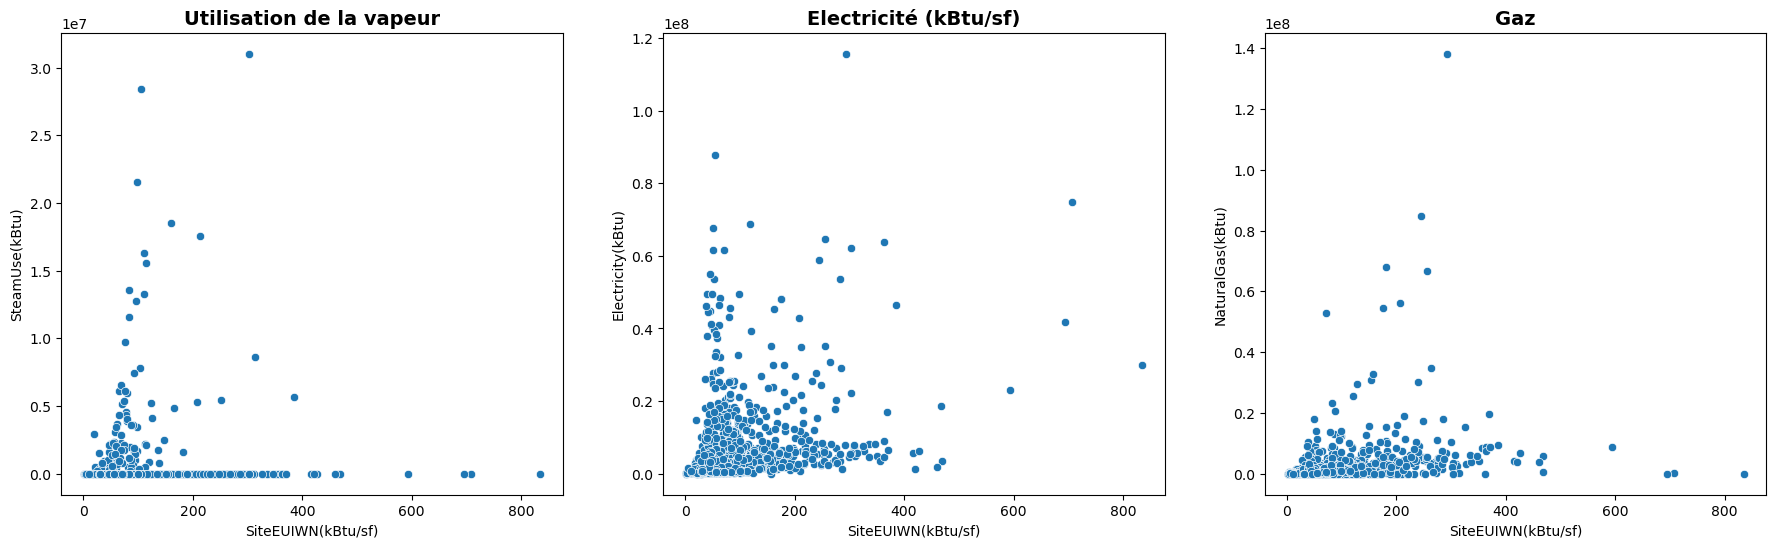

In [18]:
# Visualisation par boxplot 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize= (22,6))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax= axes[0], data=df, y="SteamUse(kBtu)", x="SiteEUIWN(kBtu/sf)") 
    axes[0].set_title("Utilisation de la vapeur", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[1], data=df, y="Electricity(kBtu)", x="SiteEUIWN(kBtu/sf)") 
    axes[1].set_title("Electricité (kBtu/sf)", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[2], data=df, y="NaturalGas(kBtu)", x="SiteEUIWN(kBtu/sf)") 
    axes[2].set_title("Gaz", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")

**2. VERIFICATION DE L'ABSENCE DE OUTLIERS SUR L'EMISSION DE GAZ A EFFET DE SERRE**

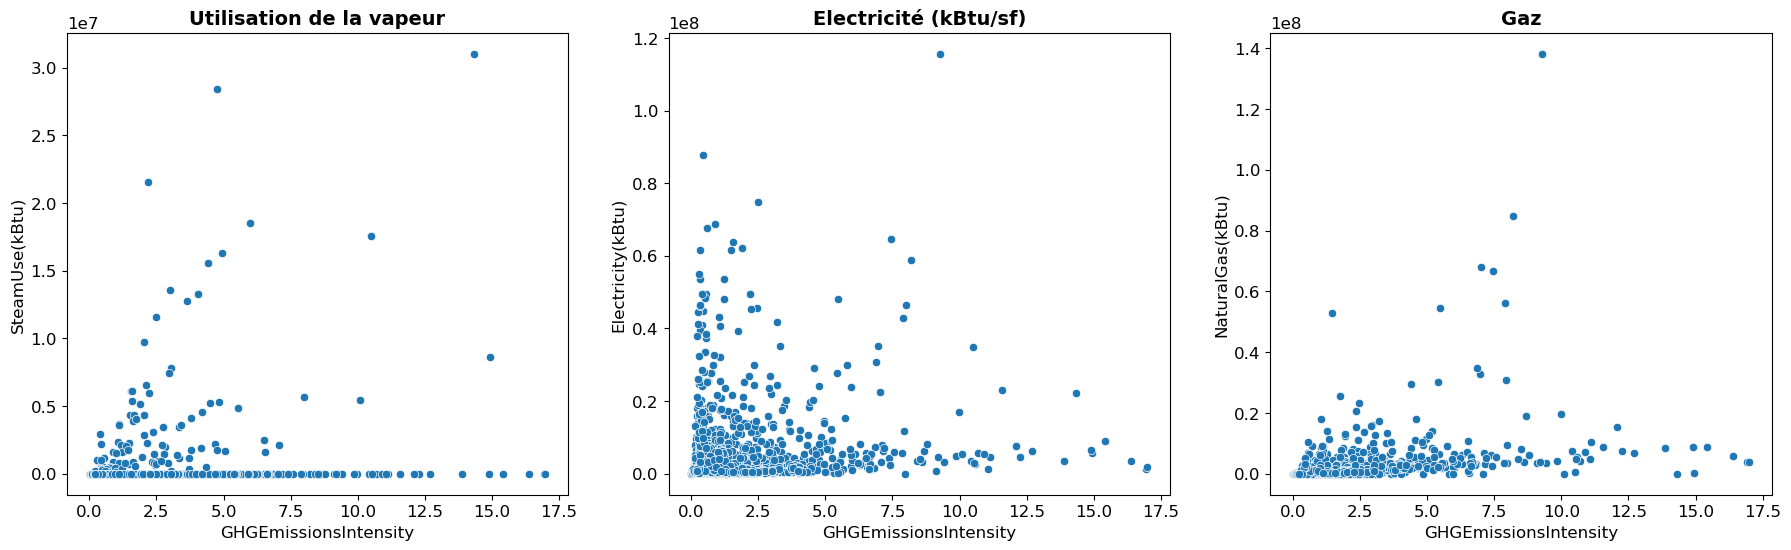

In [19]:
# Visualisation par boxplot après élimination des gros outliers
fig, axes = plt.subplots(nrows=1, ncols=3, figsize= (22,6))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax= axes[0], data=df, y="SteamUse(kBtu)", x="GHGEmissionsIntensity") 
    axes[0].set_title("Utilisation de la vapeur", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[1], data=df, y="Electricity(kBtu)", x="GHGEmissionsIntensity") 
    axes[1].set_title("Electricité (kBtu/sf)", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[2], data=df, y="NaturalGas(kBtu)", x="GHGEmissionsIntensity") 
    axes[2].set_title("Gaz", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")

**Lors de mon premier nettoyage, j'avais déjà retiré les gros outliers en me basant uniquement sur les boxplots de chaque variable. Néanmoins, je pense qu'il est préférable d'éliminer certaines propriétés présentant des valeurs atypiques pour l'utilisation de la vapeur (>2.5e7), les consommations de gaz et d'électricité (>1e8) et pour la consommation énergétique (>550). Ceci est possible car nous disposons d'un nombre suffisant de données.** 

In [20]:
outlier = df[(df["SteamUse(kBtu)"] > 25000000) | (df["Electricity(kBtu)"] > 100000000) | (df["NaturalGas(kBtu)"] > 100000000) | (info_propriete["SiteEUIWN(kBtu/sf)"] > 550)]
outlier

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
101,Hospital,NORTHEAST,47.66231,-122.28146,1953,6.0,10,879000.0,0.0,879000.0,Hospital (General Medical & Surgical),879000.0,Nothing,0.0,Nothing,0.0,10.0,293.200012,0.0,115641210.0,138191238.0,9.27
185,Data Center,NORTHEAST,47.66060,-122.31512,1969,1.0,5,36000.0,0.0,36000.0,Data Center,36000.0,Nothing,0.0,Nothing,0.0,96.0,834.400024,0.0,30038487.0,0.0,5.82
206,Hotel,DOWNTOWN,47.60804,-122.33391,1923,1.0,12,542305.0,0.0,542305.0,Hotel,542305.0,Swimming Pool,0.0,Nothing,0.0,45.0,105.199997,28438884.0,24078107.0,3968211.0,4.75
249,Mixed Use Property,LAKE UNION,47.61915,-122.34857,2001,1.0,6,213834.0,104922.0,108912.0,Parking,104922.0,Data Center,54385.0,Office,37721.0,100.0,707.299988,0.0,74917352.0,156525.0,2.48
1417,Laboratory,EAST,47.60427,-122.32311,2000,1.0,8,181930.0,0.0,181930.0,Laboratory,181930.0,Nothing,0.0,Nothing,0.0,NaN,302.700012,31030194.0,22135959.0,0.0,14.32
1423,Urgent Care and Clinic and Other Outpatient,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575.0,0.0,53575.0,Urgent Care and Clinic and Other Outpatient,53575.0,Nothing,0.0,Nothing,0.0,NaN,593.599976,0.0,23173477.0,8630089.0,11.57
1434,Data Center,DOWNTOWN,47.61449,-122.33956,1975,1.0,7,90700.0,30700.0,60000.0,Data Center,60000.0,Parking,30700.0,Nothing,0.0,100.0,694.700012,0.0,41680634.0,0.0,3.20


In [21]:
# Liste des index 7 propriétés
liste_propriete_a_supp = outlier.index.tolist()

In [22]:
# Elimination des 7 propriétés dans les 2 jeux de données
df = df[~df.index.isin(liste_propriete_a_supp)].reset_index(drop=True)
info_propriete = info_propriete[~info_propriete.index.isin(liste_propriete_a_supp)].reset_index(drop=True)

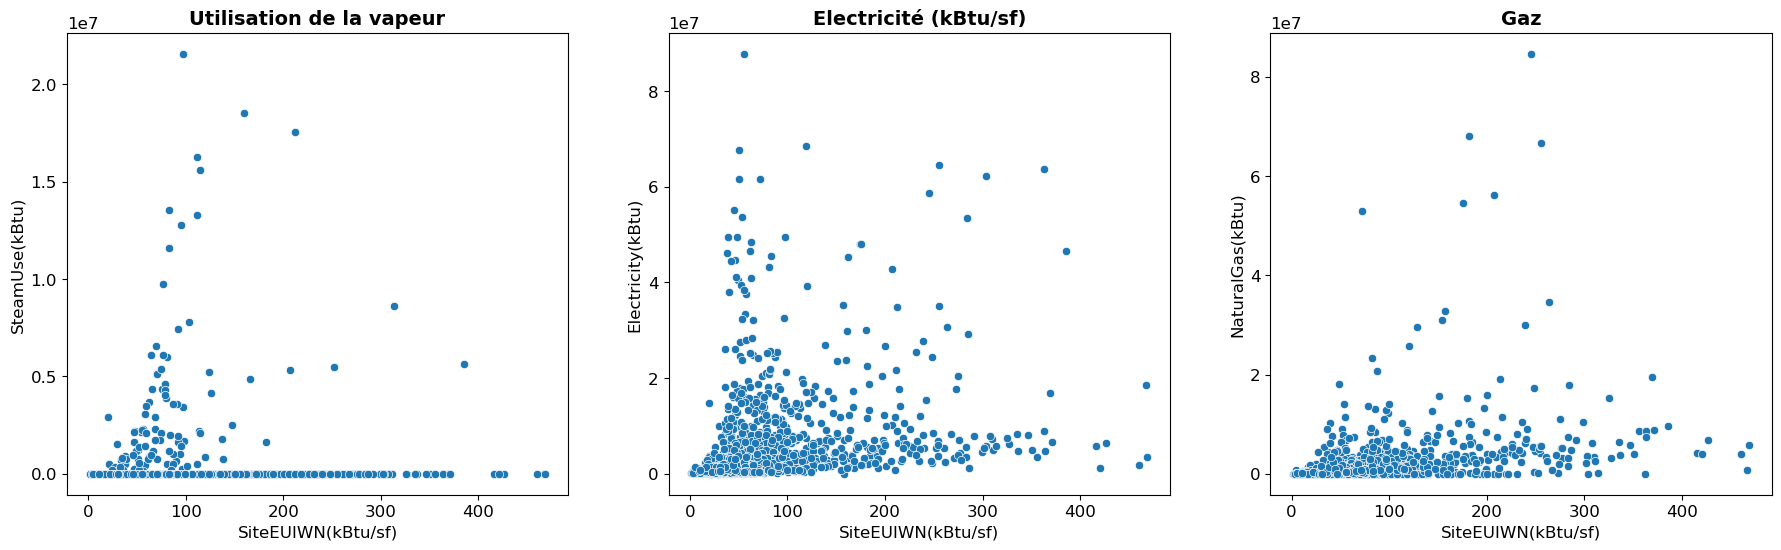

In [23]:
# Visualisation après élimination des propriétés atypiques pour la consommation énergétique
fig, axes = plt.subplots(nrows=1, ncols=3, figsize= (22,6))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax= axes[0], data=df, y="SteamUse(kBtu)", x="SiteEUIWN(kBtu/sf)") 
    axes[0].set_title("Utilisation de la vapeur", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[1], data=df, y="Electricity(kBtu)", x="SiteEUIWN(kBtu/sf)") 
    axes[1].set_title("Electricité (kBtu/sf)", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[2], data=df, y="NaturalGas(kBtu)", x="SiteEUIWN(kBtu/sf)") 
    axes[2].set_title("Gaz", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")

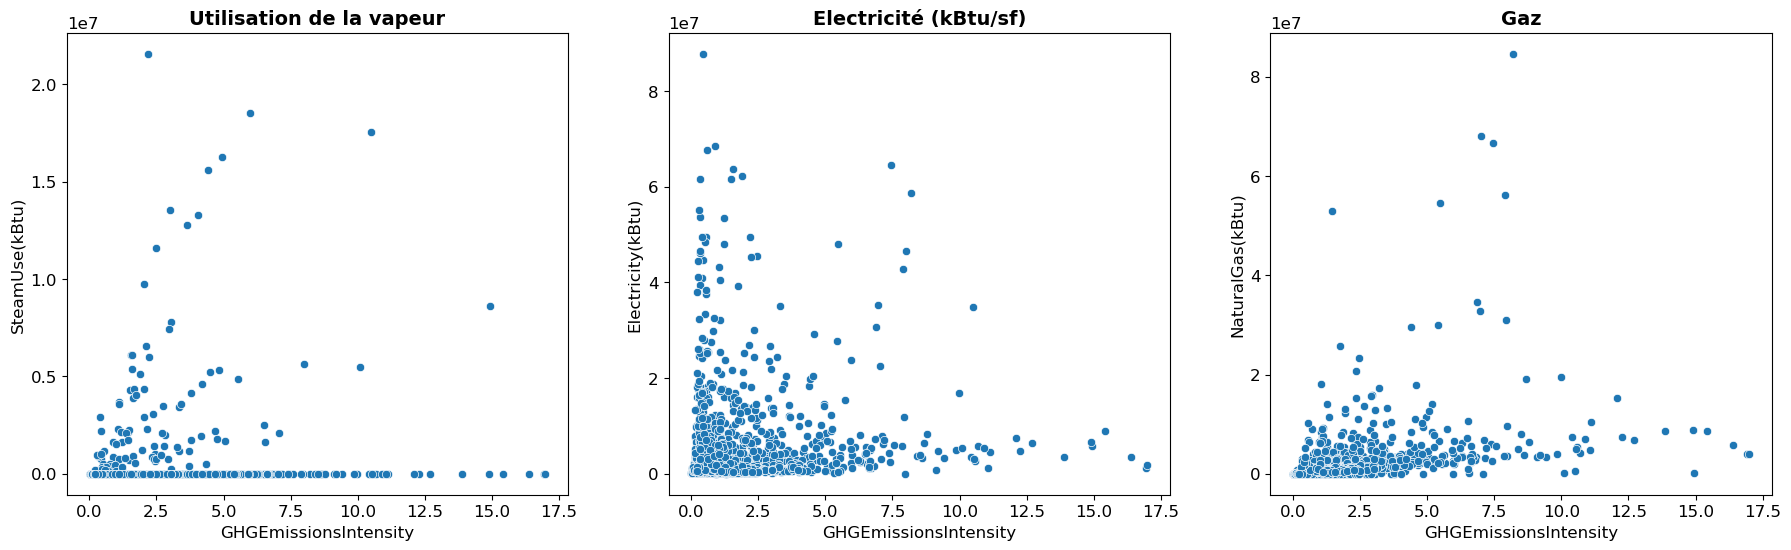

In [24]:
# Visualisation après élimination des propriétés atypiques pour l'intensité d'émission des gaz à effet de serre
fig, axes = plt.subplots(nrows=1, ncols=3, figsize= (22,6))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax= axes[0], data=df, y="SteamUse(kBtu)", x="GHGEmissionsIntensity") 
    axes[0].set_title("Utilisation de la vapeur", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[1], data=df, y="Electricity(kBtu)", x="GHGEmissionsIntensity") 
    axes[1].set_title("Electricité (kBtu/sf)", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax= axes[2], data=df, y="NaturalGas(kBtu)", x="GHGEmissionsIntensity") 
    axes[2].set_title("Gaz", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")

**Le jeu de données me semble plus harmonieux et sera donc conservé avec certains ouliers.**

**3. PASSAGE EN POURCENTAGE DES DIFFERENTS TYPES D'ENERGIE**

In [25]:
# Création d'une colonne somme énergie
df["Somme énergie"] = df["Electricity(kBtu)"] + df["NaturalGas(kBtu)"] + df["SteamUse(kBtu)"]
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,Somme énergie
0,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2003882.00,3946027.0,1276453.0,2.83,7226362.00
1,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,0.00,3242851.0,5145082.0,2.86,8387933.00
2,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,21566554.00,49526664.0,1493800.0,2.19,72587018.00
3,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,2214446.25,2768924.0,1811213.0,4.67,6794583.25
4,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,0.00,5368607.0,8803998.0,2.88,14172605.00


In [26]:
# Passage au pourcentage des différentes énergies par rapport à la somme totale de l'énergie
df["SteamUse(%)"] = (df['SteamUse(kBtu)']*100) / df['Somme énergie']
df["Electricity(%)"] = (df['Electricity(kBtu)']*100) / df['Somme énergie']
df["NaturalGas(%)"] = (df['NaturalGas(kBtu)']*100) / df['Somme énergie']
df.head()                                                    

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,Somme énergie,SteamUse(%),Electricity(%),NaturalGas(%)
0,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2003882.00,3946027.0,1276453.0,2.83,7226362.00,27.730164,54.605997,17.663840
1,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,0.00,3242851.0,5145082.0,2.86,8387933.00,0.000000,38.660907,61.339093
2,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,21566554.00,49526664.0,1493800.0,2.19,72587018.00,29.711310,68.230746,2.057944
3,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,2214446.25,2768924.0,1811213.0,4.67,6794583.25,32.591348,40.751933,26.656720
4,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,0.00,5368607.0,8803998.0,2.88,14172605.00,0.000000,37.880171,62.119829


**4. ELIMINATION DES VARIABLES 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)' et 'Somme énergie'**

In [27]:
# Elimination du jeu de données
df = df.drop(["SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)", "Somme énergie"], axis=1)
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%)
0,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840
1,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093
2,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944
3,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720
4,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829


**5. INFOS SUR LES 2 JEUX DE DONNEES**

In [28]:
# Jeu de données info_propriete
info_propriete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1483 non-null   int64  
 1   PropertyName                   1483 non-null   object 
 2   Address                        1483 non-null   object 
 3   ZipCode                        1483 non-null   float64
 4   TaxParcelIdentificationNumber  1483 non-null   object 
 5   CouncilDistrictCode            1483 non-null   int64  
 6   ListOfAllPropertyUseTypes      1483 non-null   object 
 7   SourceEUIWN(kBtu/sf)           1483 non-null   float64
 8   SiteEnergyUseWN(kBtu)          1483 non-null   float64
 9   TotalGHGEmissions              1483 non-null   float64
 10  SiteEUIWN(kBtu/sf)             1483 non-null   float64
 11  GHGEmissionsIntensity          1483 non-null   float64
 12  SteamUse(kBtu)                 1483 non-null   f

In [29]:
# Jeu de données pour la modélisation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1483 non-null   object 
 1   Neighborhood                     1483 non-null   object 
 2   Latitude                         1483 non-null   float64
 3   Longitude                        1483 non-null   float64
 4   YearBuilt                        1483 non-null   int64  
 5   NumberofBuildings                1483 non-null   float64
 6   NumberofFloors                   1483 non-null   int64  
 7   PropertyGFATotal                 1483 non-null   float64
 8   PropertyGFAParking               1483 non-null   float64
 9   PropertyGFABuilding(s)           1483 non-null   float64
 10  LargestPropertyUseType           1483 non-null   object 
 11  LargestPropertyUseTypeGFA        1483 non-null   float64
 12  SecondLargestPropert

## 1.3. Passage des targets à l'échelle logarithmique

**1. AVANT PASSAGE A L'ECHELLE LOGARITHMIQUE**

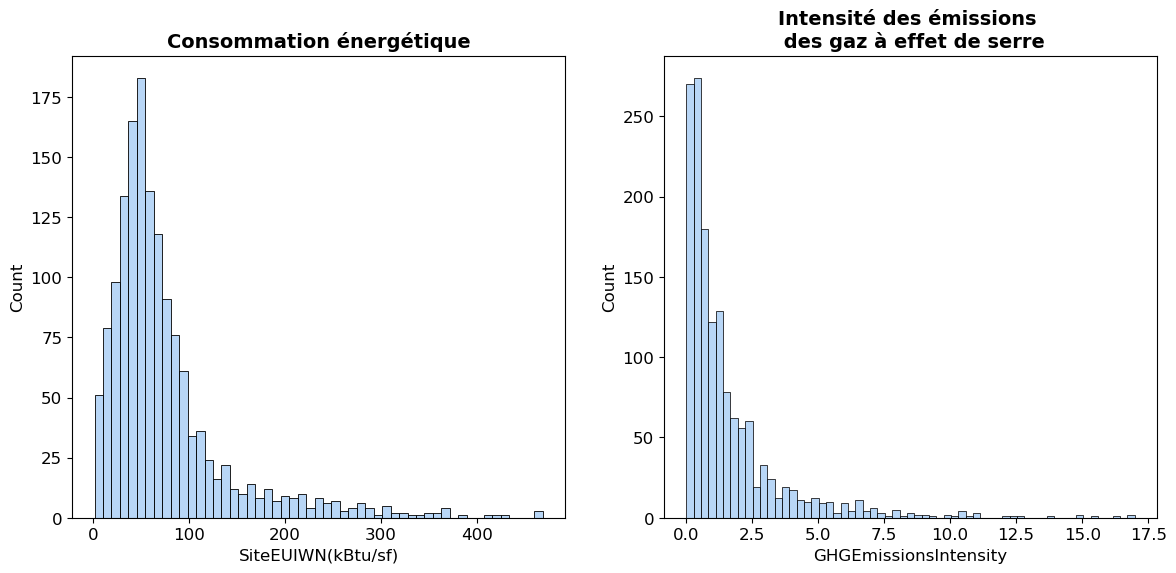

In [30]:
# Visualisation de la distribution des valeurs de nos 2 targets
fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (14,6))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.histplot(ax= axes[0], data=df, x="SiteEUIWN(kBtu/sf)") 
    axes[0].set_title("Consommation énergétique", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.histplot(ax= axes[1], data=df, x="GHGEmissionsIntensity") 
    axes[1].set_title("Intensité des émissions \n des gaz à effet de serre", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")

In [31]:
# Transformation des valeurs des targets en array
energy_array = df.iloc[:,17].values
emission_array = df.iloc[:, 18].values

# Vérification de l'asymétrie des 2 targets par le test de Skew
energy_skew_test = skewtest(energy_array)
print(f'Test sur la target énergie: {energy_skew_test.statistic}')

print()

emission_skew_test = skewtest(emission_array)
print(f'Test sur la target émission: {emission_skew_test.statistic}')

Test sur la target énergie: 23.3889295701429

Test sur la target émission: 26.672138901291113


**Bien que cela était une évidence, le test de skew montre bien que nous sommes en présence d'une asymétrie pour les 2 targets. Par conséquent, un passage à l'échelle logarithmique me semble tout à fait pertinent.**

**2. APRES PASSAGE A L'ECHELLE LOGARITHMIQUE**

In [32]:
from sklearn.preprocessing import FunctionTransformer

y_energy = df["SiteEUIWN(kBtu/sf)"]
y_gas = df["GHGEmissionsIntensity"]

logtransformer_test = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
df["SiteEUIWN(kBtu/sf)_Log"] = logtransformer_test.transform(y_energy)
df["GHGEmissionsIntensity_Log"] = logtransformer_test.transform(y_gas)

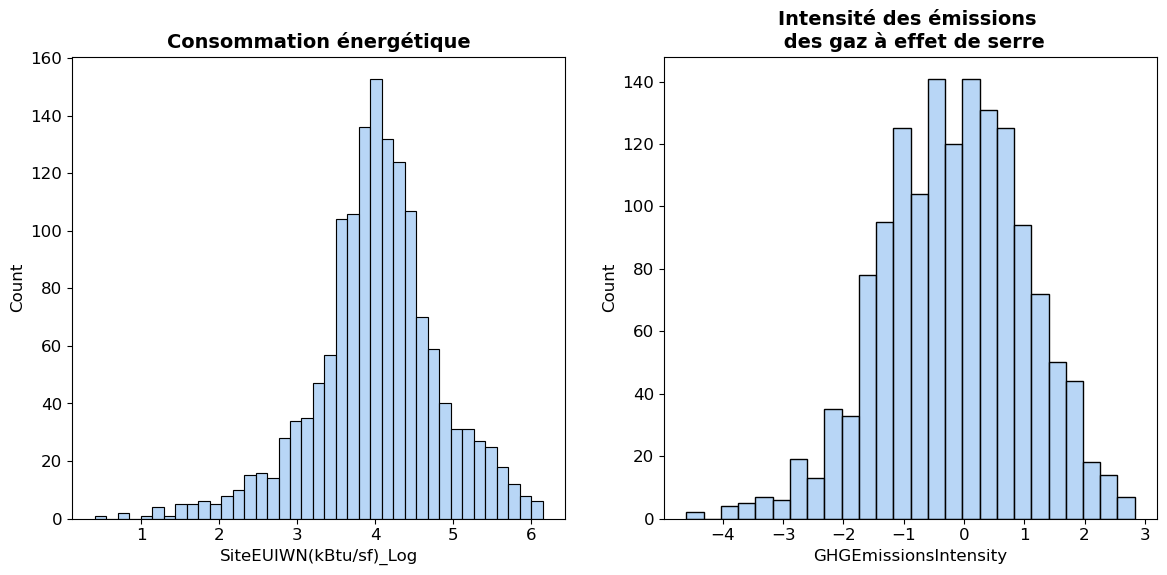

In [33]:
# Visualisation après passage à l'échelle logarithmique
fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (14,6))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.histplot(ax= axes[0], data=df, x="SiteEUIWN(kBtu/sf)_Log")
    axes[0].set_xlabel('SiteEUIWN(kBtu/sf)_Log', fontname = 'sans-serif', fontsize = 12)
    axes[0].set_title("Consommation énergétique", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.histplot(ax= axes[1], data=df, x="GHGEmissionsIntensity_Log") 
    axes[1].set_xlabel('GHGEmissionsIntensity', fontname = 'sans-serif', fontsize = 12)
    axes[1].set_title("Intensité des émissions \n des gaz à effet de serre", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")

**Ce passage à l'échelle logarithmique conduit à une distribution normale des données à prédire, permettant donc un meilleur apprentissage. Ainsi, lors des modélisations, le passage à l'échelle logarithmique des 2 cibles sera réalisé via la fonction TargetTransformerRegressor de Sklearn.**

## 1.4. Création d'une nouvelle variable pour l'âge de la propriété

**Dans le jeu de données, cette variable est de type numérique. S'agissant plutôt d'une variable catégorielle, une nouvelle variable donnant l'âge de la propriété sera créée et servira dans les modélisations, rendant ainsi les données plus pertinentes. Etant en 2023, cette date servira de référence.** 

### 1. Création de la variable AgePropriete

In [34]:
df["AgePropriete"] = 2023 - df["YearBuilt"]
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete
0,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,4.434382,1.040277,96
1,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,4.583947,1.050822,27
2,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,4.581902,0.783902,54
3,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,4.730039,1.541159,97
4,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,4.776599,1.057790,43


### 2. Stockage de la variable 'YearBuilt' dans le jeu de données info_propriete

In [35]:
# Création du 'dataframe'
variable_annee = df["YearBuilt"]

In [36]:
# Concaténation dans le jeu de données info_propriete
info_propriete = pd.concat([info_propriete, variable_annee], axis=1)
info_propriete.head()

,OSEBuildingID,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,ListOfAllPropertyUseTypes,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingType,YearBuilt
0,1,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,Hotel,189.000000,7456910.0,249.98,84.300003,2.83,2003882.00,3946027.0,1276453.0,NonResidential,1927
1,2,Paramount Hotel,724 Pine street,98101.0,0659000220,7,"Hotel, Parking, Restaurant",179.399994,8664479.0,295.86,97.900002,2.86,0.00,3242851.0,5145082.0,NonResidential,1996
2,3,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,Hotel,244.100006,73937112.0,2089.28,97.699997,2.19,21566554.00,49526664.0,1493800.0,NonResidential,1969
3,5,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,Hotel,224.000000,6946800.5,286.43,113.300003,4.67,2214446.25,2768924.0,1811213.0,NonResidential,1926
4,8,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,"Hotel, Parking, Swimming Pool",215.600006,14656503.0,505.01,118.699997,2.88,0.00,5368607.0,8803998.0,NonResidential,1980


### 3. Elimination de la variable du jeu de données de modélisation

In [37]:
df = df.drop("YearBuilt", axis=1)
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete
0,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434.0,0.0,88434.0,Hotel,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,4.434382,1.040277,96
1,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566.0,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,4.583947,1.050822,27
2,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,953211.0,196718.0,756493.0,Hotel,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,4.581902,0.783902,54
3,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320.0,0.0,61320.0,Hotel,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,4.730039,1.541159,97
4,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,191454.0,68009.0,123445.0,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,4.776599,1.057790,43


## 1.4. Création de nouvelles variables à partir de variables existantes pour les activités

### 1. La variable "PrimaryPropertyType"

**1. CONTENU**

In [38]:
print(df["PrimaryPropertyType"].unique().tolist())

['Hotel', 'Police Station', ' Entertainment and Public Assembly', 'Library', 'Fitness Center and Health Club and Gym', 'Mixed Use Property', 'Courthouse', 'Other', 'University', 'Automobile Dealership', 'Self Storage Facility', 'Warehouse', 'K 12 School', 'Small  and Mid Sized Office', 'Large Office', ' Mall', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', ' Lodging and Residential', 'Residence Hall', 'Other and Specialty Hospital', 'Financial Office', 'Distribution Center', 'Parking', 'Worship Facility', 'Supermarket  and  Grocery Store', 'Urgent Care and Clinic and Other Outpatient', 'Laboratory', ' Services', 'Strip Mall', 'Refrigerated Warehouse', 'Manufacturing and Industrial Plant', ' Recreation', 'Lifestyle Center', ' Public Services', 'Restaurant', 'Social and Meeting Hall', 'Fire Station', 'Performing Arts', 'Residential Care Facility', 'Bank Branch', ' Education', 'Food Service', 'Adult Educa

**2. NOMBRE DE TYPES D'ACTIVITE**

In [39]:
len(df["PrimaryPropertyType"].unique().tolist())

52

**Cette variable contient 52 types d'activité dont des 'Other' et des 'Mixed Use Property'. De plus, dans le notebook de nettoyage, nous avons observé que certaines activités n'étaient présentes qu'un seule fois (ex: 'Food Service' et 'Movie Theater')... Le 'Mixed Use Property' regroupe comme son nom l'indique des propriétés avec plusieurs activités, la variable 'LargestPropertyUsedType' me semble donc plus pertinente... Si tel est le cas, cette dernière pourrait remplacer la variable "PrimaryPropertyType".**

**3. DIFFERENCE ENTRE LES CONTENUS DES VARIABLES 'PrimaryPropertyType' ET 'LargestPropertyTypeUse'**

In [40]:
modification_nom = df[(df["PrimaryPropertyType"] == 'Supermarket  and  Grocery Store')]

for index in modification_nom.index:
    df.loc[index, "PrimaryPropertyType"] = 'Supermarket and Grocery Store'

In [41]:
difference_contenu = df[(df["PrimaryPropertyType"] != df["LargestPropertyUseType"])]
difference_contenu.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete
17,Mixed Use Property,DOWNTOWN,47.60515,-122.33159,1.0,5,57452.0,0.0,57452.0,Social and Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.0,NaN,137.100006,4.75,23.352383,49.497101,27.150516,4.920711,1.558145,116
22,University,DOWNTOWN,47.61816,-122.33629,1.0,7,125000.0,0.0,125000.0,College and University,125000.0,Nothing,0.0,Nothing,0.0,NaN,97.500000,3.07,0.000000,40.969703,59.030297,4.579852,1.121678,95
29,Warehouse,GREATER DUWAMISH,47.51138,-122.28875,3.0,2,963000.0,0.0,963000.0,Non Refrigerated Warehouse,616000.0,Refrigerated Warehouse,276000.0,Office,71000.0,NaN,45.799999,0.44,0.000000,100.000000,0.000000,3.824284,-0.820981,62
31,Small and Mid Sized Office,BALLARD,47.66587,-122.38476,1.0,2,94900.0,0.0,94900.0,Office,55586.0,Non Refrigerated Warehouse,39314.0,Nothing,0.0,57.0,68.900002,1.38,0.000000,69.370598,30.629402,4.232656,0.322083,62
32,Small and Mid Sized Office,GREATER DUWAMISH,47.58034,-122.31132,1.0,2,58878.0,0.0,58878.0,Office,51029.0,Education,7849.0,Nothing,0.0,83.0,53.500000,1.60,0.000000,53.526663,46.473337,3.979682,0.470004,123


**4. DATAFRAME POUR LES MIXED USED PROPERTY**

In [42]:
mixed_used_property = df[(df["PrimaryPropertyType"] == "Mixed Use Property")]
mixed_used_property.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete
17,Mixed Use Property,DOWNTOWN,47.60515,-122.33159,1.0,5,57452.000000,0.0,57452.000000,Social and Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.000000,NaN,137.100006,4.75,23.352383,49.497101,27.150516,4.920711,1.558145,116
39,Mixed Use Property,DOWNTOWN,47.60886,-122.33744,1.0,2,52459.000000,0.0,52459.000000,Entertainment and Public Assembly,23500.0,Restaurant,23500.0,Office,5459.000000,NaN,299.000000,11.12,0.000000,30.829220,69.170780,5.700444,2.408745,97
56,Mixed Use Property,EAST,47.60845,-122.32637,1.0,6,78062.000000,20868.0,57194.000000,Medical Office,40174.0,Parking,20868.0,Office,17020.000000,NaN,207.300003,4.83,34.432642,65.567358,0.000000,5.334167,1.574846,40
144,Mixed Use Property,DOWNTOWN,47.60410,-122.33958,1.0,1,65671.300049,0.0,65671.300049,Restaurant,32494.0,Other,29793.0,Retail Store,3384.300049,NaN,165.699997,6.00,0.000000,36.442301,63.557699,5.110179,1.791759,123
189,Mixed Use Property,DOWNTOWN,47.61770,-122.33060,1.0,11,384794.000000,182820.0,201974.000000,Parking,182820.0,Office,164192.0,Fitness Center and Health Club and Gym,37782.000000,94.0,49.200001,0.19,0.000000,99.037926,0.962074,3.895894,-1.660731,23


**Au regard des 2 dataframes ci-dessus, nous pouvons remarquer une redondance entre les 2 variables, avec la variable "LargestPropertyUseType" davantage détaillée surtout concernant les Mixed used Property présents dans la variable "PrimaryPropertyType". Par conséquent, je trouve davantage fiable la variable "LargestPropertyUseType" qui sera conservée comme référence pour l'activité de la propriété.**

**Les variables de type "object" qui seront à encoder avec le One Hot Encoder présentent énormément de données. De ce fait, un regroupement sera réalisé afin de réduire le nombre de colonnes en sortie.**

**Ceci est très pertinent dans notre cas car des activités ne sont même pas présentes dans 10 propriétés (cf notebook de nettoyage). Ce regroupement de bâtiments par activité améliorera la performance des modèles et leur stabilité.**

**Afin d'être homogène pour l'ensemble des variables, "LargestPropertyUseType", "SecondLargestPropertyUseType" et "ThirdLargestPropertyUseType", les activités seront regoupées par activité comme suit:**
- **Hébergement**
- **Entrepots réfrigéré et Data Center**
- **Stockage**
- **Santé et Recherche**
- **Restauration**
- **Gros commerces**
- **Petits commerces**
- **Education**
- **Bureaux**
- **Autres et services:**
- **Les usines**
- **Parking**
- **Nothing**

### 2. La variable "LargestPropertyUseType"

In [43]:
# Modification de l'activité des 3 propriétés mentionnées lors de l'analyse du type de propriétés
df.iloc[142, 9] = "Social and Meeting Hall"
df.iloc[280, 9] = "Laboratory"
df.iloc[953, 9] = "Office"

In [44]:
# Vérification de la bonne attribution sur une propriété
df.iloc[142, 9]

'Social and Meeting Hall'

In [45]:
# L'hébergement

hebergement_1 = df[(df["LargestPropertyUseType"]== 'Hotel') | (df["LargestPropertyUseType"]== 'Residence Hall') | (df["LargestPropertyUseType"]== ' Lodging and Residential') | (df["LargestPropertyUseType"]== 'Residence Hall and Dormitory')]

for index in hebergement_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Hébergement" 
    
# Nombre de propriétés concernées

print(f'{hebergement_1.shape[0]} propriétés présentent principalement une activité d\'hébergement.')

99 propriétés présentent principalement une activité d'hébergement.


In [46]:
# Les entrepôts réfrigérés et les Data Center

entrepot_1 = df[(df["LargestPropertyUseType"]== 'Refrigerated Warehouse') | (df["LargestPropertyUseType"]== "Data Center")]

for index in entrepot_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Entrepôts réfrigérés et Data Center" 
    
# Nombre de propriétés concernées

print(f'{entrepot_1.shape[0]} propriétés présentent une activité principale de Data Center ou d\'entrepôts réfrigérés.')

12 propriétés présentent une activité principale de Data Center ou d'entrepôts réfrigérés.


In [47]:
# Le stockage

stockage_1 = df[(df["LargestPropertyUseType"]== 'Non Refrigerated Warehouse') | (df["LargestPropertyUseType"]== 'Self Storage Facility') | (df["LargestPropertyUseType"]== 'Distribution Center') | (df["LargestPropertyUseType"]== 'Warehouse')]

for index in stockage_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Stockage" 
    
# Nombre de propriétés concernées

print(f'{stockage_1.shape[0]} propriétés sont principalement des lieux de stockages.')

276 propriétés sont principalement des lieux de stockages.


In [48]:
# La santé et la recherche

soin_1 = df[(df["LargestPropertyUseType"]== 'Senior Care Community') | (df["LargestPropertyUseType"]== 'Medical Office') | (df["LargestPropertyUseType"]== 'Hospital (General Medical & Surgical)') | (df["LargestPropertyUseType"]== 'Other and Specialty Hospital') | (df["LargestPropertyUseType"]== 'Laboratory') | (df["LargestPropertyUseType"]== 'Urgent Care and Clinic and Other Outpatient') | (df["LargestPropertyUseType"]== 'Residential Care Facility') | (df["LargestPropertyUseType"]== ' Technology and Science') | (df["LargestPropertyUseType"]== 'Hospital')]

for index in soin_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Santé et Recherche" 
    
# Nombre de propriétés concernées

print(f'{soin_1.shape[0]} propriétés présentent principalement des activités liées aux soins et à la recherche.')

85 propriétés présentent principalement des activités liées aux soins et à la recherche.


In [49]:
# La restauration

restauration_1 = df[(df["LargestPropertyUseType"]== 'Restaurant') | (df["LargestPropertyUseType"]== 'Food Service' ) | (df["LargestPropertyUseType"]== ' Restaurant and Bar') | (df["LargestPropertyUseType"]== 'Fast Food Restaurant')]

for index in restauration_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Restauration"

    
# Nombre de propriétés concernées

print(f'{restauration_1.shape[0]} propriétés présentent une activité principale de restauration.')

15 propriétés présentent une activité principale de restauration.


In [50]:
# Les gros commerces

gros_commerces_1 = df[(df["LargestPropertyUseType"]== ' Mall') | (df["LargestPropertyUseType"]== 'Supermarket and Grocery Store') | (df["LargestPropertyUseType"]== 'Strip Mall') | (df["LargestPropertyUseType"]== 'Enclosed Mall') | (df["LargestPropertyUseType"]== 'Automobile Dealership') | (df["LargestPropertyUseType"]== 'Food Sales' ) | (df["LargestPropertyUseType"]== 'Wholesale Club and Supercenter') | (df["LargestPropertyUseType"]== 'Lifestyle Center')]

for index in gros_commerces_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Gros commerces" 
    
# Nombre de propriétés concernées

print(f'{gros_commerces_1.shape[0]} propriétés sont principalement des zones commerciales.')

56 propriétés sont principalement des zones commerciales.


In [51]:
# Les petits commerces

petits_commerces_1 = df[(df["LargestPropertyUseType"]== 'Retail Store') | (df["LargestPropertyUseType"]== 'Personal Services (Health and Beauty, Dry Cleaning, etc)') | (df["LargestPropertyUseType"]== 'Convenience Store without Gas Station') | (df["LargestPropertyUseType"]== 'Repair Services (Vehicle, Shoe, Locksmith, etc)') | (df["LargestPropertyUseType"]== 'Library')]

for index in petits_commerces_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Petits commerces" 
    
# Nombre de propriétés concernées

print(f'{petits_commerces_1.shape[0]} propriétés sont principalement des commerces de proximité.')

100 propriétés sont principalement des commerces de proximité.


In [52]:
# L'éducation

education_1 = df[(df["LargestPropertyUseType"]== 'University') | (df["LargestPropertyUseType"]== 'K 12 School') | (df["LargestPropertyUseType"]== 'College and University') | (df["LargestPropertyUseType"]== ' Education') | (df["LargestPropertyUseType"]== 'Adult Education') | (df["LargestPropertyUseType"]== 'Pre school and Daycare') | (df["LargestPropertyUseType"]== 'Vocational School')] 

for index in education_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Education" 
    
# Nombre de propriétés concernées

print(f'{education_1.shape[0]} propriétés sont principalement des lieux d\'enseignement.')

78 propriétés sont principalement des lieux d'enseignement.


In [53]:
# Les bureaux

bureaux_1 = df[(df["LargestPropertyUseType"]== 'Office') | (df["LargestPropertyUseType"]== 'Financial Office') | (df["LargestPropertyUseType"]== 'Small  and Mid Sized Office') | (df["LargestPropertyUseType"]== 'Large Office')]

for index in bureaux_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Bureaux" 
    
# Nombre de propriétés concernées

print(f'{bureaux_1.shape[0]} propriétés sont principalement des bureaux.')

466 propriétés sont principalement des bureaux.


In [54]:
# Autres et services

autre_1 = df[(df["LargestPropertyUseType"]== 'Other') | (df["LargestPropertyUseType"]== ' Services') | (df["LargestPropertyUseType"]== ' Utility') | (df["LargestPropertyUseType"]== 'Police Station')|(df["LargestPropertyUseType"]==' Public Services')| 
            (df["LargestPropertyUseType"]== 'Courthouse') | (df["LargestPropertyUseType"]== 'Worship Facility') | (df["LargestPropertyUseType"]== 'Fire Station') | (df["LargestPropertyUseType"]== 'Bank Branch')]

for index in autre_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Autre et services" 
    
# Nombre de propriétés concernées

print(f'{autre_1.shape[0]} propriétés présentent une activité stipulée comme autre et sont des lieux de services publics.')

181 propriétés présentent une activité stipulée comme autre et sont des lieux de services publics.


In [55]:
# Loisirs, culture et lieux de rassemblement

social_1 = df[(df["LargestPropertyUseType"]== 'Social and Meeting Hall') | (df["LargestPropertyUseType"]== ' Entertainment and Public Assembly') | (df["LargestPropertyUseType"]== 'Movie Theater') | (df["LargestPropertyUseType"]== 'Performing Arts') | 
              (df["LargestPropertyUseType"]== ' Recreation') | (df["LargestPropertyUseType"]== 'Fitness Center and Health Club and Gym') | (df["LargestPropertyUseType"]== 'Museum') |(df["LargestPropertyUseType"]== 'Bar and Nightclub')]

for index in social_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Activités sociales" 
    
# Nombre de propriétés concernées

print(f'{social_1.shape[0]} propriétés sont des lieux d\'activités sociales.')    

76 propriétés sont des lieux d'activités sociales.


In [56]:
# Les usines 

usines_1 = df[(df["LargestPropertyUseType"]== 'Manufacturing and Industrial Plant')]

for index in usines_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Usines" 
    
# Nombre de propriétés concernées

print(f'{usines_1.shape[0]} propriétés sont principalement des usines.')  

8 propriétés sont principalement des usines.


In [57]:
# Le parking

parking_1 = df[(df["LargestPropertyUseType"]== 'Parking')]

for index in parking_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Parking" 
    
# Nombre de propriétés concernées
    
print(f'{parking_1.shape[0]} propriétés possèdent un parking présentant une superficie supérieure à la superficie du ou des bâtiments.')

31 propriétés possèdent un parking présentant une superficie supérieure à la superficie du ou des bâtiments.


In [58]:
# Regroupement des aucunes activités (concerne les SecondLargestPropertyType et ThirdLargestType)

aucune_activite_1 = df[(df["LargestPropertyUseType"]== 'Nothing') | (df["LargestPropertyUseType"]== 'Swimming Pool')]

for index in aucune_activite_1.index:
    df.loc[index, "LargestPropertyUseType"] = "Nothing" 
    
# Nombre de propriétés concernées

print(f'{aucune_activite_1.shape[0]} propriété ne possède aucune activité.')        

0 propriété ne possède aucune activité.


In [59]:
# Vérification du contenu de la variable PrimaryPropertyType
print(df["LargestPropertyUseType"].unique().tolist())

['Hébergement', 'Autre et services', 'Activités sociales', 'Petits commerces', 'Education', 'Gros commerces', 'Stockage', 'Bureaux', 'Santé et Recherche', 'Parking', 'Restauration', 'Entrepôts réfrigérés et Data Center', 'Usines']


### 3. La variable 'SecondLargestPropertyTypeUse'

In [60]:
# L'hébergement

hebergement_2 = df[(df["SecondLargestPropertyUseType"]== 'Hotel') | (df["SecondLargestPropertyUseType"]== 'Residence Hall') | (df["SecondLargestPropertyUseType"]== ' Lodging and Residential') | (df["SecondLargestPropertyUseType"]== 'Residence Hall and Dormitory')]

for index in hebergement_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Hébergement" 
    
# Nombre de propriétés concernées

print(f'{hebergement_2.shape[0]} propriétés présentent une activité secondaire d\'hébergement.')

4 propriétés présentent une activité secondaire d'hébergement.


In [61]:
# Les entrepôts réfrigérés et les Data Centers

entrepot_2 = df[(df["SecondLargestPropertyUseType"]== 'Refrigerated Warehouse') | (df["SecondLargestPropertyUseType"]== "Data Center")]

for index in entrepot_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Entrepôts réfrigérés et Data Center" 
    
# Nombre de propriétés concernées

print(f'{entrepot_2.shape[0]} propriétés présentent une activité secondaire de Data Center ou d\'entrepôts réfrigérés.')

12 propriétés présentent une activité secondaire de Data Center ou d'entrepôts réfrigérés.


In [62]:
# Le stockage

stockage_2 = df[(df["SecondLargestPropertyUseType"]== 'Non Refrigerated Warehouse') | (df["SecondLargestPropertyUseType"]== 'Self Storage Facility') | (df["SecondLargestPropertyUseType"]== 'Distribution Center') | (df["SecondLargestPropertyUseType"]== 'Warehouse')]

for index in stockage_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Stockage" 
    
# Nombre de propriétés concernées

print(f'{stockage_2.shape[0]} propriétés sont des lieux secondaires de stockage.')

37 propriétés sont des lieux secondaires de stockage.


In [63]:
# La santé et la recherche

soin_2 = df[(df["SecondLargestPropertyUseType"]== 'Senior Care Community') | (df["SecondLargestPropertyUseType"]== 'Medical Office') | (df["SecondLargestPropertyUseType"]== 'Hospital (General Medical & Surgical)') | (df["SecondLargestPropertyUseType"]== 'Other and Specialty Hospital') | (df["SecondLargestPropertyUseType"]== 'Laboratory') | (df["SecondLargestPropertyUseType"]== 'Urgent Care and Clinic and Other Outpatient') | (df["SecondLargestPropertyUseType"]== 'Residential Care Facility') | (df["SecondLargestPropertyUseType"]== ' Technology and Science') | (df["SecondLargestPropertyUseType"]== 'Hospital')]

for index in soin_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Santé et Recherche" 
# Nombre de propriétés concernées

print(f'{soin_2.shape[0]} propriétés présentent des activités secondaire liées aux soins et à la recherche.')

14 propriétés présentent des activités secondaire liées aux soins et à la recherche.


In [64]:
# La restauration

restauration_2 = df[(df["SecondLargestPropertyUseType"]== 'Restaurant') | (df["SecondLargestPropertyUseType"]== 'Food Service' ) | (df["SecondLargestPropertyUseType"]== ' Restaurant and Bar') | (df["SecondLargestPropertyUseType"]== 'Fast Food Restaurant')]

for index in restauration_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Restauration"

# Nombre de propriétés concernées

print(f'{restauration_2.shape[0]} propriétés présentent une activité secondaire de restauration.')

30 propriétés présentent une activité secondaire de restauration.


In [65]:
# Les gros commerces

gros_commerces_2 = df[(df["SecondLargestPropertyUseType"]== ' Mall') | (df["SecondLargestPropertyUseType"]== 'Supermarket and Grocery Store') | (df["SecondLargestPropertyUseType"]== 'Strip Mall') | (df["SecondLargestPropertyUseType"]== 'Enclosed Mall') | (df["SecondLargestPropertyUseType"]== 'Automobile Dealership') | (df["SecondLargestPropertyUseType"]== 'Food Sales' ) | (df["SecondLargestPropertyUseType"]== 'Wholesale Club and Supercenter') | (df["SecondLargestPropertyUseType"]== 'Lifestyle Center')]

for index in gros_commerces_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Gros commerces" 
    
# Nombre de propriétés concernées

print(f'{gros_commerces_2.shape[0]} propriétés sont secondairement des zones commerciales.')

12 propriétés sont secondairement des zones commerciales.


In [66]:
# Les petits commerces

petits_commerces_2 = df[(df["SecondLargestPropertyUseType"]== 'Retail Store') | (df["SecondLargestPropertyUseType"]== 'Personal Services (Health and Beauty, Dry Cleaning, etc)') | (df["SecondLargestPropertyUseType"]== 'Convenience Store without Gas Station') | (df["SecondLargestPropertyUseType"]== 'Repair Services (Vehicle, Shoe, Locksmith, etc)') | (df["SecondLargestPropertyUseType"]== 'Library')]

for index in petits_commerces_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Petits commerces" 
    
# Nombre de propriétés concernées

print(f'{petits_commerces_2.shape[0]} propriétés sont secondairement des commerces de proximité.')

86 propriétés sont secondairement des commerces de proximité.


In [67]:
# L'éducation

education_2 = df[(df["SecondLargestPropertyUseType"]== 'University') | (df["SecondLargestPropertyUseType"]== 'K 12 School') | (df["SecondLargestPropertyUseType"]== 'College and University') | (df["SecondLargestPropertyUseType"]== ' Education') | (df["SecondLargestPropertyUseType"]== 'Adult Education') | (df["SecondLargestPropertyUseType"]== 'Pre school and Daycare') | (df["SecondLargestPropertyUseType"]== 'Vocational School')] 

for index in education_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Education" 
    
# Nombre de propriétés concernées

print(f'{education_2.shape[0]} propriétés sont des lieux secondaires d\'enseignement.')

11 propriétés sont des lieux secondaires d'enseignement.


In [68]:
# Les bureaux

bureaux_2 = df[(df["SecondLargestPropertyUseType"]== 'Office') | (df["SecondLargestPropertyUseType"]== 'Financial Office') | (df["SecondLargestPropertyUseType"]== 'Small  and Mid Sized Office') | (df["SecondLargestPropertyUseType"]== 'Large Office')]

for index in bureaux_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Bureaux" 
    
# Nombre de propriétés concernées

print(f'{bureaux_2.shape[0]} propriétés sont secondairement des bureaux.')

161 propriétés sont secondairement des bureaux.


In [69]:
# Autres et services

autre_2 = df[(df["SecondLargestPropertyUseType"]== 'Other') | (df["SecondLargestPropertyUseType"]== ' Services') | (df["SecondLargestPropertyUseType"]== ' Utility') | (df["SecondLargestPropertyUseType"]== 'Police Station')|(df["SecondLargestPropertyUseType"]==' Public Services')| 
            (df["SecondLargestPropertyUseType"]== 'Courthouse') | (df["SecondLargestPropertyUseType"]== 'Worship Facility') | (df["SecondLargestPropertyUseType"]== 'Fire Station') | (df["SecondLargestPropertyUseType"]== 'Bank Branch')]

for index in autre_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Autre et services" 
    
# Nombre de propriétés concernées

print(f'{autre_2.shape[0]} propriétés présentent une activité secondaire stipulée comme autre et sont des lieux de services publics.')

63 propriétés présentent une activité secondaire stipulée comme autre et sont des lieux de services publics.


In [70]:
# Loisirs, culture et lieux de rassemblement

social_2 = df[(df["SecondLargestPropertyUseType"]== 'Social and Meeting Hall') | (df["SecondLargestPropertyUseType"]== ' Entertainment and Public Assembly') | (df["SecondLargestPropertyUseType"]== 'Movie Theater') | (df["SecondLargestPropertyUseType"]== 'Performing Arts') | 
              (df["SecondLargestPropertyUseType"]== ' Recreation') | (df["SecondLargestPropertyUseType"]== 'Fitness Center and Health Club and Gym') | (df["SecondLargestPropertyUseType"]== 'Museum') |(df["SecondLargestPropertyUseType"]== 'Bar and Nightclub')]

for index in social_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Activités sociales" 
    
# Nombre de propriétés concernées

print(f'{social_2.shape[0]} propriétés sont des lieux secondaires d\'activités sociales.')    

33 propriétés sont des lieux secondaires d'activités sociales.


In [71]:
# Les usines 

usines_2 = df[(df["SecondLargestPropertyUseType"]== 'Manufacturing and Industrial Plant')]

for index in usines_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Usines" 
    
# Nombre de propriétés concernées

print(f'{usines_2.shape[0]} propriétés sont secondairement des usines.')  

2 propriétés sont secondairement des usines.


In [72]:
# Le parking

parking_2 = df[(df["SecondLargestPropertyUseType"]== 'Parking')]

for index in parking_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Parking" 
    
print(f'{parking_2.shape[0]} propriétés possèdent un parking en activité secondaire.')

389 propriétés possèdent un parking en activité secondaire.


In [73]:
# Regroupement des aucunes activités (concerne surtout les SecondLargestPropertyType et ThirdLargestType).

aucune_activite_2 = df[(df["SecondLargestPropertyUseType"]== 'Nothing') | (df["SecondLargestPropertyUseType"]== 'Swimming Pool')]

for index in aucune_activite_2.index:
    df.loc[index, "SecondLargestPropertyUseType"] = "Nothing" 
    
# Nombre de propriétés concernées

print(f'{aucune_activite_2.shape[0]} propriétés ne possèdent pas d\'activité secondaire.')        

629 propriétés ne possèdent pas d'activité secondaire.


In [74]:
# Vérification du contenu de la variable PrimaryPropertyType
print(df["SecondLargestPropertyUseType"].unique().tolist())

['Nothing', 'Parking', 'Bureaux', 'Restauration', 'Entrepôts réfrigérés et Data Center', 'Stockage', 'Education', 'Petits commerces', 'Activités sociales', 'Autre et services', 'Hébergement', 'Santé et Recherche', 'Gros commerces', 'Usines']


### 4. La variable 'ThirdLargestPropertyTypeUse'

In [75]:
# L'hébergement

hebergement_3 = df[(df["ThirdLargestPropertyUseType"]== 'Hotel') | (df["ThirdLargestPropertyUseType"]== 'Residence Hall') | (df["ThirdLargestPropertyUseType"]== ' Lodging and Residential') | (df["ThirdLargestPropertyUseType"]== 'Residence Hall and Dormitory')]

for index in hebergement_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Hébergement" 
    
# Nombre de propriétés concernées

print(f'{hebergement_3.shape[0]} propriétés présentent une activité tertiaire d\'hébergement.')

0 propriétés présentent une activité tertiaire d'hébergement.


In [76]:
# Les entrepôts réfrigérés et les Data Centers

entrepot_3 = df[(df["ThirdLargestPropertyUseType"]== 'Refrigerated Warehouse') | (df["ThirdLargestPropertyUseType"]== "Data Center")]

for index in entrepot_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Entrepôts réfrigérés et Data Center" 
    
# Nombre de propriétés concernées

print(f'{entrepot_3.shape[0]} propriétés présentent une activité tertiaire de Data Center ou d\'entrepôts réfrigérés.')

16 propriétés présentent une activité tertiaire de Data Center ou d'entrepôts réfrigérés.


In [77]:
# Le stockage

stockage_3 = df[(df["ThirdLargestPropertyUseType"]== 'Non Refrigerated Warehouse') | (df["ThirdLargestPropertyUseType"]== 'Self Storage Facility') | (df["ThirdLargestPropertyUseType"]== 'Distribution Center') | (df["ThirdLargestPropertyUseType"]== 'Warehouse')]

for index in stockage_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Stockage" 
    
# Nombre de propriétés concernées

print(f'{stockage_3.shape[0]} propriétés sont des lieux tertaire de stockage.')

18 propriétés sont des lieux tertaire de stockage.


In [78]:
# La santé et la recherche

soin_3 = df[(df["ThirdLargestPropertyUseType"]== 'Senior Care Community') | (df["ThirdLargestPropertyUseType"]== 'Medical Office') | (df["ThirdLargestPropertyUseType"]== 'Hospital (General Medical & Surgical)') | (df["ThirdLargestPropertyUseType"]== 'Other and Specialty Hospital') | (df["ThirdLargestPropertyUseType"]== 'Laboratory') | (df["ThirdLargestPropertyUseType"]== 'Urgent Care and Clinic and Other Outpatient') | (df["ThirdLargestPropertyUseType"]== 'Residential Care Facility') | (df["ThirdLargestPropertyUseType"]== ' Technology and Science') | (df["ThirdLargestPropertyUseType"]== 'Hospital')]

for index in soin_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Santé et Recherche" 

# Nombre de propriétés concernées

print(f'{soin_3.shape[0]} propriétés présentent des activités tertiaires liées aux soins et à la recherche.')

18 propriétés présentent des activités tertiaires liées aux soins et à la recherche.


In [79]:
# La restauration

restauration_3 = df[(df["ThirdLargestPropertyUseType"]== 'Restaurant') | (df["ThirdLargestPropertyUseType"]== 'Food Service' ) | (df["ThirdLargestPropertyUseType"]== ' Restaurant and Bar') | (df["ThirdLargestPropertyUseType"]== 'Fast Food Restaurant')]

for index in restauration_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Restauration"

# Nombre de propriétés concernées

print(f'{restauration_3.shape[0]} propriétés présentent une activité tertiare de restauration.')

42 propriétés présentent une activité tertiare de restauration.


In [80]:
# Les gros commerces

gros_commerces_3 = df[(df["ThirdLargestPropertyUseType"]== ' Mall') | (df["ThirdLargestPropertyUseType"]== 'Supermarket and Grocery Store') | (df["ThirdLargestPropertyUseType"]== 'Strip Mall') | (df["ThirdLargestPropertyUseType"]== 'Enclosed Mall') | (df["ThirdLargestPropertyUseType"]== 'Automobile Dealership') | (df["ThirdLargestPropertyUseType"]== 'Food Sales' ) | (df["ThirdLargestPropertyUseType"]== 'Wholesale Club and Supercenter') | (df["ThirdLargestPropertyUseType"]== 'Lifestyle Center')]

for index in gros_commerces_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Gros commerces" 
    
# Nombre de propriétés concernées

print(f'{gros_commerces_3.shape[0]} propriétés sont des zones commerciales au niveau de l\'activité tertiaire.')

2 propriétés sont des zones commerciales au niveau de l'activité tertiaire.


In [81]:
# Les petits commerces

petits_commerces_3 = df[(df["ThirdLargestPropertyUseType"]== 'Retail Store') | (df["ThirdLargestPropertyUseType"]== 'Personal Services (Health and Beauty, Dry Cleaning, etc)') | (df["ThirdLargestPropertyUseType"]== 'Convenience Store without Gas Station') | (df["ThirdLargestPropertyUseType"]== 'Repair Services (Vehicle, Shoe, Locksmith, etc)') | (df["ThirdLargestPropertyUseType"]== 'Library')]

for index in petits_commerces_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Petits commerces" 
    
# Nombre de propriétés concernées

print(f'{petits_commerces_3.shape[0]} propriétés sont des commerces de proximité au niveau de l\'activité tertiaire.')

45 propriétés sont des commerces de proximité au niveau de l'activité tertiaire.


In [82]:
# L'éducation

education_3 = df[(df["ThirdLargestPropertyUseType"]== 'University') | (df["ThirdLargestPropertyUseType"]== 'K 12 School') | (df["ThirdLargestPropertyUseType"]== 'College and University') | (df["ThirdLargestPropertyUseType"]== ' Education') | (df["ThirdLargestPropertyUseType"]== 'Adult Education') | (df["ThirdLargestPropertyUseType"]== 'Pre school and Daycare') | (df["ThirdLargestPropertyUseType"]== 'Vocational School')] 

for index in education_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Education" 
    
# Nombre de propriétés concernées

print(f'{education_3.shape[0]} propriétés sont des lieux tertiaires d\'enseignement.')

13 propriétés sont des lieux tertiaires d'enseignement.


In [83]:
# Les bureaux

bureaux_3 = df[(df["ThirdLargestPropertyUseType"]== 'Office') | (df["ThirdLargestPropertyUseType"]== 'Financial Office') | (df["ThirdLargestPropertyUseType"]== 'Small  and Mid Sized Office') | (df["ThirdLargestPropertyUseType"]== 'Large Office')]

for index in bureaux_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Bureaux" 
    
# Nombre de propriétés concernées

print(f'{bureaux_3.shape[0]} propriétés sont tertiairement des bureaux.')

51 propriétés sont tertiairement des bureaux.


In [84]:
# Autres et services

autre_3 = df[(df["ThirdLargestPropertyUseType"]== 'Other') | (df["ThirdLargestPropertyUseType"]== ' Services') | (df["ThirdLargestPropertyUseType"]== ' Utility') | (df["ThirdLargestPropertyUseType"]== 'Police Station')|(df["ThirdLargestPropertyUseType"]==' Public Services')| 
            (df["ThirdLargestPropertyUseType"]== 'Courthouse') | (df["ThirdLargestPropertyUseType"]== 'Worship Facility') | (df["ThirdLargestPropertyUseType"]== 'Fire Station') | (df["ThirdLargestPropertyUseType"]== 'Bank Branch')]

for index in autre_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Autre et services" 
    
# Nombre de propriétés concernées

print(f'{autre_3.shape[0]} propriétés présentent une activité tertiare stipulée comme autre et sont des lieux de services publics.')

49 propriétés présentent une activité tertiare stipulée comme autre et sont des lieux de services publics.


In [85]:
# Loisirs, culture et lieux de rassemblement

social_3 = df[(df["ThirdLargestPropertyUseType"]== 'Social and Meeting Hall') | (df["ThirdLargestPropertyUseType"]== ' Entertainment and Public Assembly') | (df["ThirdLargestPropertyUseType"]== 'Movie Theater') | (df["ThirdLargestPropertyUseType"]== 'Performing Arts') | 
              (df["ThirdLargestPropertyUseType"]== ' Recreation') | (df["ThirdLargestPropertyUseType"]== 'Fitness Center and Health Club and Gym') | (df["ThirdLargestPropertyUseType"]== 'Museum') |(df["ThirdLargestPropertyUseType"]== 'Bar and Nightclub')]

for index in social_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Activités sociales" 
    
# Nombre de propriétés concernées

print(f'{social_3.shape[0]} propriétés sont des lieux tertiaires d\'activités sociales.')    

17 propriétés sont des lieux tertiaires d'activités sociales.


In [86]:
# Les usines 

usines_3 = df[(df["ThirdLargestPropertyUseType"]== 'Manufacturing and Industrial Plant')]

for index in usines_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Usines" 
    
# Nombre de propriétés concernées

print(f'{usines_3.shape[0]} propriété possède une usine comme activité tertiaire.')

1 propriété possède une usine comme activité tertiaire.


In [87]:
# Le parking

parking_3 = df[(df["ThirdLargestPropertyUseType"]== 'Parking')]

for index in parking_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Parking" 
    
print(f'{parking_3.shape[0]} propriétés possèdent un parking en activité tertiaire.')

38 propriétés possèdent un parking en activité tertiaire.


In [88]:
# Regroupement des aucunes activités (concerne surtout les SecondLargestPropertyType et ThirdLargestType).

aucune_activite_3 = df[(df["ThirdLargestPropertyUseType"]== 'Nothing') | (df["ThirdLargestPropertyUseType"]== 'Swimming Pool')]

for index in aucune_activite_3.index:
    df.loc[index, "ThirdLargestPropertyUseType"] = "Nothing" 
    
# Nombre de propriétés concernées

print(f'{aucune_activite_3.shape[0]} propriétés ne possèdent pas d\'activité tertiaire.')        

1173 propriétés ne possèdent pas d'activité tertiaire.


In [89]:
# Vérification du contenu de la variable ThirdLargestPropertyUseType
print(df["ThirdLargestPropertyUseType"].unique().tolist())

['Nothing', 'Restauration', 'Entrepôts réfrigérés et Data Center', 'Bureaux', 'Petits commerces', 'Autre et services', 'Stockage', 'Santé et Recherche', 'Parking', 'Education', 'Activités sociales', 'Usines', 'Gros commerces']


## 1.6. Gestion des variables fortement corrélées par transformation

**Dans le précédent notebook, 4 fortes corrélations linéaires ont été observées au niveau des superficies:(PropertyGFAParking/SecondLargestPropertyUseTypeGFA, PropertyGFATotal/LargestPropertyUseTypeGFA, PropertyGFATotal/PropertyGFABuilding(s) et PropertyGFABuilding(s)/LargestPropertyUseTypeGFA). Ainsi, une vigilance devra être portée dans la sélection des différentes variables lors de la modélisation.**

**Il s'agit donc d'atténuer les corrélations pour les superficies en conservant forcément la variable "PropertyGFATotal".**

### 1. Passage en pourcentage de la superficie totale pour les toutes variables contenant des superficies

**1. CREATION DES VARIABLES 'ParkingGFA(%)' et "BatimentGFA(%)'**

In [90]:
df["ParkingGFA(%)"] = (df["PropertyGFAParking"]*100)/df["PropertyGFATotal"]
df["BatimentGFA(%)"] = (df["PropertyGFABuilding(s)"]*100)/df["PropertyGFATotal"]
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete,ParkingGFA(%),BatimentGFA(%)
0,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434.0,0.0,88434.0,Hébergement,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,4.434382,1.040277,96,0.000000,100.000000
1,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566.0,15064.0,88502.0,Hébergement,83880.0,Parking,15064.0,Restauration,4622.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,4.583947,1.050822,27,14.545314,85.454686
2,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,953211.0,196718.0,756493.0,Hébergement,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,4.581902,0.783902,54,20.637403,79.362597
3,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320.0,0.0,61320.0,Hébergement,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,4.730039,1.541159,97,0.000000,100.000000
4,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,191454.0,68009.0,123445.0,Hébergement,123445.0,Parking,68009.0,Nothing,0.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,4.776599,1.057790,43,35.522371,64.477629


**2. CREATION DES VARIABLES 'LargestPropertyUseGFA(%)', 'SecondLargestPropertyUseGFA(%)' et 'ThirdLargestPropertyUseGFA(%)'**

In [91]:
df["LargestPropertyUseTypeGFA(%)"] = (df["LargestPropertyUseTypeGFA"]*100)/df["PropertyGFATotal"]
df["SecondLargestPropertyUseTypeGFA(%)"] = (df["SecondLargestPropertyUseTypeGFA"]*100)/df["PropertyGFATotal"]
df["ThirdLargestPropertyUseTypeGFA(%)"] = (df["ThirdLargestPropertyUseTypeGFA"]*100)/df["PropertyGFATotal"]
df.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete,ParkingGFA(%),BatimentGFA(%),LargestPropertyUseTypeGFA(%),SecondLargestPropertyUseTypeGFA(%),ThirdLargestPropertyUseTypeGFA(%)
0,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434.0,0.0,88434.0,Hébergement,88434.0,Nothing,0.0,Nothing,0.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,4.434382,1.040277,96,0.000000,100.000000,100.000000,0.000000,0.000000
1,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566.0,15064.0,88502.0,Hébergement,83880.0,Parking,15064.0,Restauration,4622.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,4.583947,1.050822,27,14.545314,85.454686,80.991831,14.545314,4.462855
2,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,953211.0,196718.0,756493.0,Hébergement,756493.0,Parking,196718.0,Nothing,0.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,4.581902,0.783902,54,20.637403,79.362597,79.362597,20.637403,0.000000
3,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320.0,0.0,61320.0,Hébergement,61320.0,Nothing,0.0,Nothing,0.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,4.730039,1.541159,97,0.000000,100.000000,100.000000,0.000000,0.000000
4,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,191454.0,68009.0,123445.0,Hébergement,123445.0,Parking,68009.0,Nothing,0.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,4.776599,1.057790,43,35.522371,64.477629,64.477629,35.522371,0.000000


### 2. Analyse de la multicolinéarité des variables quantitatives (hors targets)

**La multicolinéarité pouvant impacter les performances des modèles de ML, le calcul du facteur d'inflation de la variance sera réalisé.**

**1. CREATION DU DATAFRAME SPECIAL FIV**

In [92]:
fiv = df[["NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "ParkingGFA(%)", "BatimentGFA(%)", "LargestPropertyUseTypeGFA(%)", "SecondLargestPropertyUseTypeGFA(%)", "ThirdLargestPropertyUseTypeGFA(%)", "AgePropriete", "SteamUse(%)", "Electricity(%)", "NaturalGas(%)"]]
fiv.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ParkingGFA(%),BatimentGFA(%),LargestPropertyUseTypeGFA(%),SecondLargestPropertyUseTypeGFA(%),ThirdLargestPropertyUseTypeGFA(%),AgePropriete,SteamUse(%),Electricity(%),NaturalGas(%)
0,1.0,12,88434.0,0.000000,100.000000,100.000000,0.000000,0.000000,96,27.730164,54.605997,17.663840
1,1.0,11,103566.0,14.545314,85.454686,80.991831,14.545314,4.462855,27,0.000000,38.660907,61.339093
2,1.0,41,953211.0,20.637403,79.362597,79.362597,20.637403,0.000000,54,29.711310,68.230746,2.057944
3,1.0,10,61320.0,0.000000,100.000000,100.000000,0.000000,0.000000,97,32.591348,40.751933,26.656720
4,1.0,18,191454.0,35.522371,64.477629,64.477629,35.522371,0.000000,43,0.000000,37.880171,62.119829


**2. PREMIER CALCUL: Prise en compte de toutes les variables**

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

datas = fiv[["NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "ParkingGFA(%)", "BatimentGFA(%)", "LargestPropertyUseTypeGFA(%)", "SecondLargestPropertyUseTypeGFA(%)", "ThirdLargestPropertyUseTypeGFA(%)", "AgePropriete", "SteamUse(%)", "Electricity(%)", "NaturalGas(%)"]]

# Création du dataframe pour le FIV
fiv_datas = pd.DataFrame()
fiv_datas["feature"] = datas.columns
  
# Calcul de fiv pour chaque variable
fiv_datas["VIF"] = [variance_inflation_factor(datas.values, i) for i in range(len(datas.columns))]
  
print(fiv_datas)

                               feature        VIF
0                    NumberofBuildings   1.052835
1                       NumberofFloors   2.121911
2                     PropertyGFATotal   2.224086
3                        ParkingGFA(%)        inf
4                       BatimentGFA(%)        inf
5         LargestPropertyUseTypeGFA(%)  34.754739
6   SecondLargestPropertyUseTypeGFA(%)  25.343596
7    ThirdLargestPropertyUseTypeGFA(%)   4.615948
8                         AgePropriete   1.250476
9                          SteamUse(%)        inf
10                      Electricity(%)        inf
11                       NaturalGas(%)        inf


C:\Users\colin\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


**En général, le seuil de multicolinéarité est fixé à 10 (voire 5 pour les personnes davantage stringeantes). Ainsi, au-delà de ce seuil, il serait souhaitable d'éliminer une ou des variables. La meilleure approche qui n'induirait aucune perte d'information serait d'éliminer la variable 'BatimentGFA(%)'. En effet, cette dernière étant totalement corrélée au "ParkingGFA(%)" et "PropertyGFATotal", aucune info ne serait perdue...**

**2. DEUXIEME CALCUL: Elimination de la variable 'BatimentGFA(%)'**

In [94]:
datas_2 = fiv[["NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "ParkingGFA(%)", "LargestPropertyUseTypeGFA(%)", "SecondLargestPropertyUseTypeGFA(%)", "ThirdLargestPropertyUseTypeGFA(%)", "AgePropriete", "SteamUse(%)", "Electricity(%)", "NaturalGas(%)"]]

# Création du dataframe pour le FIV
fiv_datas_2 = pd.DataFrame()
fiv_datas_2["feature"] = datas_2.columns
  
# Calcul de fiv pour chaque variable
fiv_datas_2["VIF"] = [variance_inflation_factor(datas_2.values, i) for i in range(len(datas_2.columns))]
  
print(fiv_datas_2)

                               feature         VIF
0                    NumberofBuildings    1.052835
1                       NumberofFloors    2.121911
2                     PropertyGFATotal    2.224086
3                        ParkingGFA(%)    1.870713
4         LargestPropertyUseTypeGFA(%)   34.754739
5   SecondLargestPropertyUseTypeGFA(%)   25.343596
6    ThirdLargestPropertyUseTypeGFA(%)    4.615948
7                         AgePropriete    1.250476
8                          SteamUse(%)    9.762063
9                       Electricity(%)  551.926537
10                       NaturalGas(%)  146.009286


**Cette option est plus correcte.**

**3. POUR INFO: Calcul du FIV sans feature engineering**

In [95]:
datas_3 = df[["NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA", "AgePropriete", "SteamUse(%)", "Electricity(%)", "NaturalGas(%)"]]

# Création du dataframe pour le FIV
fiv_datas_3 = pd.DataFrame()
fiv_datas_3["feature"] = datas_3.columns
  
# Calcul de fiv pour chaque variable
fiv_datas_3["VIF"] = [variance_inflation_factor(datas_3.values, i) for i in range(len(datas_3.columns))]
  
print(fiv_datas_3)

                            feature         VIF
0                 NumberofBuildings    1.079919
1                    NumberofFloors    2.199034
2                  PropertyGFATotal         inf
3                PropertyGFAParking         inf
4            PropertyGFABuilding(s)         inf
5         LargestPropertyUseTypeGFA  946.970837
6   SecondLargestPropertyUseTypeGFA   99.538930
7    ThirdLargestPropertyUseTypeGFA   13.376267
8                      AgePropriete    1.147156
9                       SteamUse(%)    1.207014
10                   Electricity(%)    4.363478
11                    NaturalGas(%)    2.269815


C:\Users\colin\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


**Conclusion: Le feature engineering était indispensable!!! L'option 2 semble pertinente mais une autre solution me parait encore meilleure. Il s'agit de rapporter les % d'activités par rapport à la superficie totale du bâtiment, ceci constituant une sorte d'encodage manuel. Une fois ce dernier réalisé, 8 variables du jeu initial deviennent inutiles: 'ParkingGFA', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'.**

### 3. Encodage "manuel" pour les activités des propriétés

**1. CREATION DE LA FONCTION D'ENCODAGE**

In [96]:
def encoder_propertyusedtype(df):
    
    df_1 = df.copy()
    
    l1 = df["LargestPropertyUseType"].unique().tolist()
    l2 = df["SecondLargestPropertyUseType"].unique().tolist()
    l3 = df["ThirdLargestPropertyUseType"].unique().tolist()
    full_l = l1 + l2 + l3
    full_l = list(set(full_l))
    full_l = [element for element in full_l if str(element) != "Nothing"]

    for property_type in full_l:
        df_1[str(property_type)]=0.0

    for index, row in df_1.iterrows():
        #print(f'total GFA : {row["PropertyGFATotal"]}')
        for prop, gfa in zip(["LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType"],
                       ["LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseTypeGFA"]):

            if (type(row[prop]) == str) & (row[gfa] > 0):
                perc = (row[gfa]/row["PropertyGFATotal"])*100
                #print(f'{row[prop]} : {perc}%')
                df_1.loc[index, str(row[prop])] = perc
            else:
                if (row[gfa] > 0):
                    print(f'Warning encoded : {row[prop]} - {row[gfa]}')

    return df_1.drop(["LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseTypeGFA",
                      "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType",
                      "LargestPropertyUseTypeGFA(%)", "SecondLargestPropertyUseTypeGFA(%)", "ThirdLargestPropertyUseTypeGFA(%)",
                     "PropertyGFAParking", "PropertyGFABuilding(s)", "ParkingGFA(%)", "BatimentGFA(%)"], axis=1)

**2. EXECUTION DE LA LA FONCTION**

In [97]:
df_1 = encoder_propertyusedtype(df=df)
df_1.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage
0,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,4.434382,1.040277,96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0
1,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,4.583947,1.050822,27,0.0,0.0,0.0,0.0,0.0,14.545314,0.0,4.462855,80.991831,0.0,0.0,0.0,0.0
2,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,4.581902,0.783902,54,0.0,0.0,0.0,0.0,0.0,20.637403,0.0,0.000000,79.362597,0.0,0.0,0.0,0.0
3,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,4.730039,1.541159,97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0
4,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,4.776599,1.057790,43,0.0,0.0,0.0,0.0,0.0,35.522371,0.0,0.000000,64.477629,0.0,0.0,0.0,0.0


In [98]:
print(f'Le nouveau jeu de données comprend {df_1.shape[1]} variables.')

Le nouveau jeu de données comprend 29 variables.


In [99]:
# Informations sur le jeu de données
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PrimaryPropertyType                  1483 non-null   object 
 1   Neighborhood                         1483 non-null   object 
 2   Latitude                             1483 non-null   float64
 3   Longitude                            1483 non-null   float64
 4   NumberofBuildings                    1483 non-null   float64
 5   NumberofFloors                       1483 non-null   int64  
 6   PropertyGFATotal                     1483 non-null   float64
 7   ENERGYSTARScore                      967 non-null    float64
 8   SiteEUIWN(kBtu/sf)                   1483 non-null   float64
 9   GHGEmissionsIntensity                1483 non-null   float64
 10  SteamUse(%)                          1483 non-null   float64
 11  Electricity(%)                

## 1.7. Latitude/Longitude, distance Haversienne ou Neighborhood

### 1. Transformation de la latitude et de la longitude en distance Haversienne

**L'analyse exploratoire a permis de mettre en évidence que la localisation (via la variable "Neighborhood")  semble avoir un impact sur nos targets. C'est pourquoi, les variables "Latitude" et "Longitude" sont d'un intérêt majeur. Néanmoins, après recherche sur internet, ces variables ne sont pas souvent utilisées telles quelles mais sont 'tranformées' en distance car elles peuvent impacter certains modèles. Par conséquent et par précaution, ces dernières seront donc converties en distance de Haversine (très utilisée en navigation), permettant de calculer la distance entre 2 points en tenant compte que la Terre est sphérique. De plus, il semblerait que cela améliorerait les performances des modélisations.**

In [100]:
from math import radians, cos, sin, asin, sqrt

# Coordonnées du centre de Seattle
seattle_lat = 47.6062095
seattle_lgn = -122.3320708

def haversine_dist(lat1,lng1,lat2,lng2):
    
    # rayon de la terre en miles d'après la NASA
    radius = 3963 
    
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # Formule de Haversine 
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    
    return h

In [101]:
# Calculs des distances par rapport au centre de Seattle pour chaque point

df_1['Haversine_distance'] = [haversine_dist(seattle_lat, seattle_lgn, x, y) for x, y in zip(df_1.Latitude.astype(float), df_1.Longitude.astype(float))]
df_1.head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),SiteEUIWN(kBtu/sf)_Log,GHGEmissionsIntensity_Log,AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage,Haversine_distance
0,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,4.434382,1.040277,96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.497867
1,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,4.583947,1.050822,27,0.0,0.0,0.0,0.0,0.0,14.545314,0.0,4.462855,80.991831,0.0,0.0,0.0,0.0,0.489183
2,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,4.581902,0.783902,54,0.0,0.0,0.0,0.0,0.0,20.637403,0.0,0.000000,79.362597,0.0,0.0,0.0,0.0,0.603495
3,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,4.730039,1.541159,97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.587170
4,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,4.776599,1.057790,43,0.0,0.0,0.0,0.0,0.0,35.522371,0.0,0.000000,64.477629,0.0,0.0,0.0,0.0,0.652243


In [102]:
# Description de la variable 'Haversine_distance'
df_1['Haversine_distance'].describe()

count    1483.000000
mean        2.758002
std         2.200395
min         0.019920
25%         0.863938
50%         2.142270
75%         4.156025
max         8.858406
Name: Haversine_distance, dtype: float64

### 2. La distance Haversienne versus la variable "Neighborhood"

**Ces 2 variables présentant une redondance, il est indispensable de n'en sélectionner qu'une seule. Une visualisation par boxplot de la distance Haversienne sera donc réalisée.**

<Figure size 2200x2200 with 0 Axes>

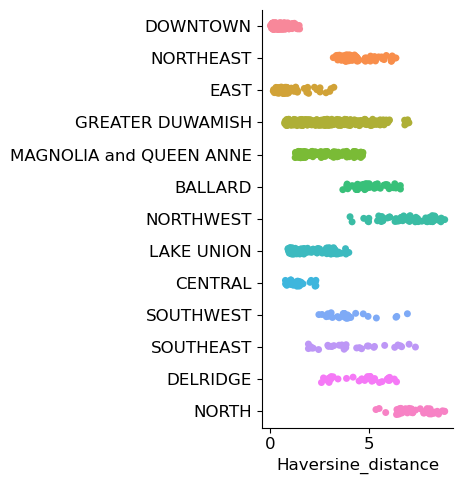

In [103]:
plt.figure(figsize=(22,22))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.catplot(data=df_1, x="Haversine_distance", y="Neighborhood") 
    plt.ylabel("")
plt.show()

**Cette visualisation a été une grande source d'informations. En effet, la transformation des données latitude/longitude en distance haversienne a permis d'obtenir des FIV corrects. Néanmoins, cette transformation ne nous permet plus de distinguer les quartiers ce qui est une énorme perte d'informations car nous avions vu qu'il y semblait y avoir une corrélation entre les quartiers et nos targets. Après réflexion, ceci est du au fait que j'ai pris comme référence le centre de la ville Seattle comme point de référence. En effet, nous voyons par exemple que les distances Haversiennes entre les quartiers Southwest et Southest sont juxtaposables. Par conséquent, je n'ai pas pris le bon point de repère pour le calcul et trouver LE point idéal semble compliquer pour notre projet.**

**Cette tentative m'a appris beaucoup de choses et la variable "Neighborhood" (voire Latitude/Longitude) sera conservée pour la modélisation.**

## 1.8. Création du jeu de données pour les 2 modélisations

**1. CREATION D'UN DATAFRAME AVEC LES VARIABLES A SUPPRIMER DE MANIERE CERTAINE**

In [104]:
# Variable du jeu de données df à inclure
variables_poubelle_1 = df[["PrimaryPropertyType", "LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseTypeGFA",
                      "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType",
                      "LargestPropertyUseTypeGFA(%)", "SecondLargestPropertyUseTypeGFA(%)", "ThirdLargestPropertyUseTypeGFA(%)",
                     "PropertyGFAParking", "PropertyGFABuilding(s)", "ParkingGFA(%)", "BatimentGFA(%)",
                          "Latitude", "Longitude", "Neighborhood"]]

# Variable du jeu de données df_1 à inclure
variables_poubelle_2 = df_1[['Haversine_distance']]

# Concaténation des 3 dataframes
info_propriete = pd.concat([info_propriete, variables_poubelle_1, variables_poubelle_2], axis =1)
info_propriete.head()

,OSEBuildingID,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,ListOfAllPropertyUseTypes,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingType,YearBuilt,PrimaryPropertyType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,LargestPropertyUseTypeGFA(%),SecondLargestPropertyUseTypeGFA(%),ThirdLargestPropertyUseTypeGFA(%),PropertyGFAParking,PropertyGFABuilding(s),ParkingGFA(%),BatimentGFA(%),Latitude,Longitude,Neighborhood,Haversine_distance
0,1,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,Hotel,189.000000,7456910.0,249.98,84.300003,2.83,2003882.00,3946027.0,1276453.0,NonResidential,1927,Hotel,88434.0,0.0,0.0,Hébergement,Nothing,Nothing,100.000000,0.000000,0.000000,0.0,88434.0,0.000000,100.000000,47.61220,-122.33799,DOWNTOWN,0.497867
1,2,Paramount Hotel,724 Pine street,98101.0,0659000220,7,"Hotel, Parking, Restaurant",179.399994,8664479.0,295.86,97.900002,2.86,0.00,3242851.0,5145082.0,NonResidential,1996,Hotel,83880.0,15064.0,4622.0,Hébergement,Parking,Restauration,80.991831,14.545314,4.462855,15064.0,88502.0,14.545314,85.454686,47.61317,-122.33393,DOWNTOWN,0.489183
2,3,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,Hotel,244.100006,73937112.0,2089.28,97.699997,2.19,21566554.00,49526664.0,1493800.0,NonResidential,1969,Hotel,756493.0,196718.0,0.0,Hébergement,Parking,Nothing,79.362597,20.637403,0.000000,196718.0,756493.0,20.637403,79.362597,47.61393,-122.33810,DOWNTOWN,0.603495
3,5,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,Hotel,224.000000,6946800.5,286.43,113.300003,4.67,2214446.25,2768924.0,1811213.0,NonResidential,1926,Hotel,61320.0,0.0,0.0,Hébergement,Nothing,Nothing,100.000000,0.000000,0.000000,0.0,61320.0,0.000000,100.000000,47.61412,-122.33664,DOWNTOWN,0.587170
4,8,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,"Hotel, Parking, Swimming Pool",215.600006,14656503.0,505.01,118.699997,2.88,0.00,5368607.0,8803998.0,NonResidential,1980,Hotel,123445.0,68009.0,0.0,Hébergement,Parking,Nothing,64.477629,35.522371,0.000000,68009.0,123445.0,35.522371,64.477629,47.61375,-122.34047,DOWNTOWN,0.652243


In [105]:
print(f'Le jeu de données non utilisées pour les modélisations comprend {info_propriete.shape[1]} variables pour les {info_propriete.shape[0]} propriétés.')

Le jeu de données non utilisées pour les modélisations comprend 35 variables pour les 1483 propriétés.


**2. ELIMINATION DES VARIABLES NON PERTINENTES POUR LA CREATION DU DATASET DE MODELISATION**

In [106]:
# Elimination des 3 variables
df_1 = df_1.drop(["PrimaryPropertyType", "Latitude", "Longitude", "Haversine_distance", "SiteEUIWN(kBtu/sf)_Log", "GHGEmissionsIntensity_Log"], axis=1)
df_1.head()

,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage
0,DOWNTOWN,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0
1,DOWNTOWN,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,27,0.0,0.0,0.0,0.0,0.0,14.545314,0.0,4.462855,80.991831,0.0,0.0,0.0,0.0
2,DOWNTOWN,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,54,0.0,0.0,0.0,0.0,0.0,20.637403,0.0,0.000000,79.362597,0.0,0.0,0.0,0.0
3,DOWNTOWN,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0
4,DOWNTOWN,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,43,0.0,0.0,0.0,0.0,0.0,35.522371,0.0,0.000000,64.477629,0.0,0.0,0.0,0.0


In [107]:
# Changement de la casse pour le contenu de la variable 'Neighborhood'
df_1["Neighborhood"] = df_1["Neighborhood"].str.lower()
df_1.head()

,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage
0,downtown,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0
1,downtown,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,27,0.0,0.0,0.0,0.0,0.0,14.545314,0.0,4.462855,80.991831,0.0,0.0,0.0,0.0
2,downtown,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,54,0.0,0.0,0.0,0.0,0.0,20.637403,0.0,0.000000,79.362597,0.0,0.0,0.0,0.0
3,downtown,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0
4,downtown,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,43,0.0,0.0,0.0,0.0,0.0,35.522371,0.0,0.000000,64.477629,0.0,0.0,0.0,0.0


In [108]:
print(f'Le jeu de données pour les modélisations comprend {df_1.shape[1]} variables et {df_1.shape[0]} propriétés.')

Le jeu de données pour les modélisations comprend 24 variables et 1483 propriétés.


**3. SAUVEGARDE DES 2 JEUX DE DONNEES POUR LEUR UTILISATION DANS LE PROCHAIN NOTEBOOK**

**Sauvegarde du jeu de données info_propriete**

In [109]:
info_propriete = info_propriete.to_csv("info_propriete.csv", index=False)

**Sauvegarde du jeu de données pour la modélisation**

In [110]:
data_modelisation = df_1.to_csv("data_modelisation.csv", index = False)

# 2. Preprocessing pour la prédiction de la consommation en énergie

## 2.1. Import des librairies

In [111]:
# Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning

# Preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Data split
from sklearn.model_selection import train_test_split

# Train time
import time

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Métrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cross Validation
from sklearn.model_selection import cross_val_score, GridSearchCV

# Valeurs de Shapley
import shap

## 2.2. Encodage de la variable catégorielle

In [112]:
# Encodage de la variable catégorielle via pd.get_dummies
df_encoded = pd.get_dummies(df_1, columns = ["Neighborhood"])
df_encoded.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia and queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,27,0.0,0.0,0.0,0.0,0.0,14.545314,0.0,4.462855,80.991831,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,54,0.0,0.0,0.0,0.0,0.0,20.637403,0.0,0.000000,79.362597,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,43,0.0,0.0,0.0,0.0,0.0,35.522371,0.0,0.000000,64.477629,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [113]:
# Dimension du jeu de données après encodage
print(f'Après encodage des données catégorielles, le jeu de données contient désormais {df_encoded.shape[1]} colonnes.')

Après encodage des données catégorielles, le jeu de données contient désormais 36 colonnes.


## 2.3. Séparation du jeu de données 

### 1. Création du jeu de validation et du jeu de modélisation

In [114]:
validation = df_encoded[df_1["ENERGYSTARScore"].isna()]
validation.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia and queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
5,1.0,2,126028.0,NaN,141.600006,3.10,0.000000,60.988402,39.011598,24,0.000000,0.0,0.0,0.000000,0.0,29.515663,0.0,0.000000,0.0,0.000000,0.000000,70.484337,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,1.0,8,102761.0,NaN,68.800003,2.16,36.142257,57.741817,6.115926,97,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,100.000000,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
14,1.0,11,414987.0,NaN,51.099998,0.44,3.967751,96.032249,0.000000,19,0.258803,0.0,0.0,0.000000,0.0,11.807599,0.0,0.000000,0.0,87.933598,0.000000,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
15,1.0,6,130000.0,NaN,78.400002,4.18,46.124599,44.733739,9.141662,93,0.000000,0.0,0.0,30.769231,0.0,0.000000,0.0,0.000000,0.0,0.000000,69.230769,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
17,1.0,5,57452.0,NaN,137.100006,4.75,23.352383,49.497101,27.150516,116,0.000000,0.0,0.0,16.955023,0.0,0.000000,0.0,26.987746,0.0,0.000000,28.618673,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [115]:
print(f'Le jeu de validation comprend {validation.shape[0]} propriétés.')

Le jeu de validation comprend 516 propriétés.


In [116]:
# Sauvegarde du jeu de validation
jeu_validation = validation.to_csv("jeu_validation.csv", index=False)

### 2. Création du jeu de d'entrainement et du jeu de test

In [117]:
modelisation = df_encoded.dropna()
modelisation.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Gros commerces,Usines,Bureaux,Education,Parking,Santé et Recherche,Restauration,Hébergement,Petits commerces,Activités sociales,Autre et services,Stockage,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia and queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,27,0.0,0.0,0.0,0.0,0.0,14.545314,0.0,4.462855,80.991831,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,54,0.0,0.0,0.0,0.0,0.0,20.637403,0.0,0.000000,79.362597,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,43,0.0,0.0,0.0,0.0,0.0,35.522371,0.0,0.000000,64.477629,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [118]:
print(f'Le jeu de modélisation encodé comprend {modelisation.shape[0]} propriétés.')

Le jeu de modélisation encodé comprend 967 propriétés.


In [119]:
# Sauvegarde pour le prochain notebook
modelisation_jeu = modelisation.to_csv("jeu_modelisation.csv", index = False)

In [120]:
# Séparation X_energy, y_energy

X = modelisation.drop(["SiteEUIWN(kBtu/sf)", "GHGEmissionsIntensity", "ENERGYSTARScore"], axis=1)
y = modelisation["SiteEUIWN(kBtu/sf)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
# Vérification des dimensions 
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (773, 33)
X_test: (194, 33)
y_train: (773,)
y_test: (194,)


*Tout est OK*

## 2.4. Fonction de passage de la target y à l'échelle logarithmique

In [122]:
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# 3. Modélisation pour la prédiction de la consommation en énergie

**Après recherche sur internet, le modèle de LinearRegression est un modèle très souvent utilisé comme baseline. Ce dernier servira donc de baseline pour les modélisations.**

**Choix des modèles**
- **3 modèles de régression linéaire seront testés et comparées, et ce avec ou sous recherche des meilleurs paramètres:**
    - **Le modèle Lasso**
    - **Le modèle Ridge**
    - **Le modèle ElasticNet**
- **3 modèles de régression linéaire non linéaires, méthodes ensemblistes, seront entrainés de façon similaire:**
    - **Le modèle RandomForestRegressor**
    - **Le modèle GradientBoostingRegressor**
    - **Le modèle XGBRegressor**

**Les méthodes ensemblistes reposant sur des arbres de décision sont généralement plus performantes que les modèles "classiques". Comme les arbres de décision ne nécessitent pas un 'Scaling' des données, j'ai pris des modèles de régression linéaire insensible au scaling des données pour la prédiction (ils mettent juste plus de temps à converger). Par conséquent, le KNN et le SVR, sensibles au scaling, sont exclus. En revanche, si le choix se porte sur un de ces modèles (je suis sure que ce ne sera pas la cas), il sera nécessaire de scaler les données pour sortir les coefficients d'importance des variables...**

##  3.1. Modélisation sans recherche de paramètres

### 1. Liste des modèles à tester

In [123]:
models = [LinearRegression(), Ridge(random_state=42), Lasso(random_state=42), ElasticNet(random_state=42), 
          RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42), XGBRegressor()]

### 2. Création d'une fonction pour comparer l'ensemble des modèles en une fois sans recherche de paramètres

In [124]:
def basic_energy(models):
    '''Comparaison des différents modèles pour la prédiction de la consommation en énergie'''
    
    print('Comparaison des différents modèles pour la prédiction de la consommation en énergie') 
 
    cols = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RFR', 'GBR', 'XGBR']
    index = ['Training Time', 'Train R²','Train RMSE', 'Train MSE', 'Train MAE', 'Test R²','Test RMSE', 'Test MSE', 'Test MAE']
    
    results_standard = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in models:
        model_regressor = TransformedTargetRegressor(regressor=model, transformer=transformer)
        model_fit = model_regressor.fit(X_train, y_train)
        model_y_pred_train = model_regressor.predict(X_train)
        model_y_pred_test = model_regressor.predict(X_test)

        results_standard.iloc[0,col] = time.time() - start_time
        
        results_standard.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_standard.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_standard.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_standard.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train)
       
        results_standard.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_standard.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_standard.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_standard.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_standard

In [125]:
results_standard = basic_energy(models=models)
results_standard

Comparaison des différents modèles pour la prédiction de la consommation en énergie


,LinearRegression,Ridge,Lasso,ElasticNet,RFR,GBR,XGBR
Training Time,0.012702,0.025505,0.049137,0.065884,1.12785,1.407364,2.007535
Train R²,0.566386,0.566168,0.429531,0.491093,0.893437,0.73301,0.993598
Train RMSE,38.695159,38.704901,44.383445,41.920284,19.182597,30.363566,4.701817
Train MSE,1497.315325,1498.069331,1969.890171,1757.310241,367.972036,921.946123,22.107087
Train MAE,23.153982,23.140432,25.753467,24.567122,9.42841,17.61397,2.488531
Test R²,0.527032,0.527473,0.436409,0.480473,0.50413,0.489696,0.452347
Test RMSE,31.375479,31.360862,34.249702,32.883547,32.126134,32.590371,33.761938
Test MSE,984.420695,983.503687,1173.042069,1081.327643,1032.088512,1062.132253,1139.868445
Test MAE,20.869678,20.836738,22.359822,21.207503,21.284427,21.113808,23.227955


**CONCLUSION: Concernant les méthodes ensemblistes, nous sommes déjà en présence de résultats très prometteurs sans réglage de paramètres. Néanmoins, un passage via GridSearchCV sera effectué afin d'effectuer à minima des cross-validation.**

## 3.2. Modélisation avec recherche des paramètres via GridSearchCV

### 1. La Linear Regression

In [126]:
# Il n'existe pas de paramètres pour la régression linéaire
baseline_1 = LinearRegression()

### 2. Le modèle Ridge

In [127]:
ridge = Ridge(normalize=True, random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
ridge_regressor = TransformedTargetRegressor(regressor=ridge, transformer=transformer)

# Dictionnaire des paramètres testés
ridge_param = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'regressor__max_iter': [10, 100, 200, 400, 600, 800, 1000]}

# Recherche des meilleurs paramètres
grid_ridge = GridSearchCV(ridge_regressor, param_grid= ridge_param, cv = 5, scoring='r2')
grid_ridge.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_ridge = grid_ridge.best_params_
best_param_ridge

{'regressor__alpha': 0.001, 'regressor__max_iter': 10}

In [128]:
ridge_1 = Ridge(alpha=0.001, max_iter=10, random_state=42, normalize=True)

### 3. Le modèle Lasso

In [129]:
'''lasso = Lasso(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
lasso_regressor = TransformedTargetRegressor(regressor=lasso, transformer=transformer)

# Dictionnaire des paramètres testés
lasso_param = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'regressor__max_iter': [1000, 2000, 5000, 10000]}

# Recherche des meilleurs paramètres
grid_lasso = GridSearchCV(lasso_regressor, param_grid= lasso_param, cv = 5, scoring='r2')
grid_lasso.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_lasso = grid_lasso.best_params_
best_param_lasso'''

"lasso = Lasso(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nlasso_regressor = TransformedTargetRegressor(regressor=lasso, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nlasso_param = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'regressor__max_iter': [1000, 2000, 5000, 10000]}\n\n# Recherche des meilleurs paramètres\ngrid_lasso = GridSearchCV(lasso_regressor, param_grid= lasso_param, cv = 5, scoring='r2')\ngrid_lasso.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_lasso = grid_lasso.best_params_\nbest_param_lasso"

output : {'regressor__alpha': 0.001, 'regressor__max_iter': 1000}

In [130]:
lasso_1 = Lasso(alpha=0.001, max_iter=1000, random_state=42, normalize=True)

### 4. L'elasticNet

In [131]:
'''el = ElasticNet(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
el_regressor = TransformedTargetRegressor(regressor=el, transformer=transformer)

# Dictionnaire des paramètres testés
el_param = {'regressor__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'regressor__alpha':[10 ,1 , 0.1, 0.01, 0.001], 'regressor__max_iter': [500, 1000, 2000, 5000]}

# Recherche des meilleurs paramètres
grid_el = GridSearchCV(el_regressor, param_grid= el_param, cv = 5, scoring='r2')
grid_el.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_el = grid_el.best_params_
best_param_el'''

"el = ElasticNet(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nel_regressor = TransformedTargetRegressor(regressor=el, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nel_param = {'regressor__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'regressor__alpha':[10 ,1 , 0.1, 0.01, 0.001], 'regressor__max_iter': [500, 1000, 2000, 5000]}\n\n# Recherche des meilleurs paramètres\ngrid_el = GridSearchCV(el_regressor, param_grid= el_param, cv = 5, scoring='r2')\ngrid_el.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_el = grid_el.best_params_\nbest_param_el"

output: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0, 'regressor__max_iter': 500}

In [132]:
el_1 = ElasticNet(alpha=0.01, l1_ratio=0, max_iter= 500, random_state=42)

**Le l1 ratio étant de 0, nous sommes en présence d'un modèle Ridge**

### 5. Le Random Forest Regressor

In [133]:
'''rfr = RandomForestRegressor(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
rfr_regressor = TransformedTargetRegressor(regressor=rfr, transformer=transformer)

# Dictionnaire des paramètres testés
rfr_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [5, 10, 15,20], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_rfr = GridSearchCV(rfr_regressor, param_grid= rfr_param, cv = 5, scoring='r2', n_jobs= -1)
grid_rfr.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_rfr = grid_rfr.best_params_
best_param_rfr'''

"rfr = RandomForestRegressor(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nrfr_regressor = TransformedTargetRegressor(regressor=rfr, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nrfr_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [5, 10, 15,20], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_rfr = GridSearchCV(rfr_regressor, param_grid= rfr_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_rfr.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_rfr = grid_rfr.best_params_\nbest_param_rfr"

output: {'regressor__criterion': 'absolute_error', 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 50}

In [134]:
rfr_1 = RandomForestRegressor(criterion='absolute_error', max_depth=20, max_features='sqrt', n_estimators = 50, random_state= 42)

### 6. Le Gradient Boosting Regressor

In [135]:
'''gbr = GradientBoostingRegressor(random_state=42)

# Définir la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
gbr_regressor = TransformedTargetRegressor(regressor=gbr, transformer=transformer)

# Dictionnaire des paramètres testés
gbr_param = {'regressor__n_estimators': [50, 100, 200, 400, 1000], 'regressor__max_features': ['sqrt', 'log2'], 
            'regressor__max_depth': [5, 10, 15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_gbr = GridSearchCV(gbr_regressor, param_grid= gbr_param, cv = 5, scoring='r2', n_jobs= -1)
grid_gbr.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_gbr = grid_gbr.best_params_
best_param_gbr'''

"gbr = GradientBoostingRegressor(random_state=42)\n\n# Définir la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\ngbr_regressor = TransformedTargetRegressor(regressor=gbr, transformer=transformer)\n\n# Dictionnaire des paramètres testés\ngbr_param = {'regressor__n_estimators': [50, 100, 200, 400, 1000], 'regressor__max_features': ['sqrt', 'log2'], \n            'regressor__max_depth': [5, 10, 15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_gbr = GridSearchCV(gbr_regressor, param_grid= gbr_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_gbr.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_gbr = grid_gbr.best_params_\nbest_param_gbr"

output : {'regressor__criterion': 'absolute_error', 'regressor__max_depth': 10, 'regressor__max_features': 'sqrt',
'regressor__n_estimators': 100}

In [136]:
gbr_1 = GradientBoostingRegressor(n_estimators=100, max_depth=10, max_features='sqrt', criterion= 'squared_error', random_state=42)

### 7. Le XGBRegressor

In [137]:
xgbr = XGBRegressor()

# Définir la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
xgbr_regressor = TransformedTargetRegressor(regressor=xgbr, transformer=transformer)

# Dictionnaire des paramètres testés
xgbr_param = {'regressor__n_estimators':[10,50,100,500,1000], 'regressor__max_depth': [2,4,8,16]}

# Recherche des meilleurs paramètres
grid_xgbr = GridSearchCV(xgbr_regressor, param_grid= xgbr_param, cv = 5, scoring='r2', n_jobs= -1)
grid_xgbr.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_xgbr = grid_xgbr.best_params_
best_param_xgbr

{'regressor__max_depth': 2, 'regressor__n_estimators': 50}

In [138]:
xgbr_1 = XGBRegressor(n_estimators=50, max_depth=2)

### 8. Comparaison des différents modèles après optimisation

**1. LISTE DES MODELES OPTIMISES**

In [139]:
optimized_models = [baseline_1, ridge_1, lasso_1, el_1, rfr_1 ,gbr_1, xgbr_1]

**2. CREATION D'UNE FONCTION PERMETTANT LA COMPARAISON DES DIFFERENTS MODELES APRES OPTIMISATION**

In [140]:
def optimized_energy(models):
    '''Comparaison des différents modèles pour la prédiction en consommation d'énergie'''
    
    print('Comparaison des différents modèles pour la prédiction la consommation en énergie après GridSearchCV') 
 
    cols = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RFR', 'GBR', 'XGBR']
    index = ['Grid Training Time', 'Grid Train R²','Grid Train RMSE', 'Grid Train MSE', 'Grid Train MAE', 'Grid Test R²','Grid Test RMSE', 'Grid Test MSE', 'Grid Test MAE']
    
    results_optimized = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in optimized_models:
        model_fit = model.fit(X_train, y_train)
        model_y_pred_train = model.predict(X_train)
        model_y_pred_test = model.predict(X_test)

        results_optimized.iloc[0,col] = time.time() - start_time
       
        results_optimized.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_optimized.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_optimized.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_optimized.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train)
        
        results_optimized.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_optimized.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_optimized.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_optimized.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_optimized

In [141]:
results_optimized = optimized_energy(models=optimized_models)
results_optimized

Comparaison des différents modèles pour la prédiction la consommation en énergie après GridSearchCV


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.999e+05, tolerance: 2.669e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


,LinearRegression,Ridge,Lasso,ElasticNet,RFR,GBR,XGBR
Grid Training Time,0.014315,0.022668,0.050628,0.129862,1.603764,1.80675,1.904382
Grid Train R²,0.555011,0.555006,0.554992,0.553906,0.912153,0.998212,0.728402
Grid Train RMSE,39.199428,39.199647,39.200288,39.248065,17.416808,2.484572,30.624462
Grid Train MSE,1536.595151,1536.612295,1536.662603,1540.410609,303.345205,6.1731,937.857653
Grid Train MAE,25.040228,25.038394,25.030529,24.855676,10.705327,1.680279,20.032042
Grid Test R²,0.41836,0.418983,0.420176,0.430508,0.502572,0.48517,0.496288
Grid Test RMSE,34.793804,34.775164,34.739433,34.428527,32.176591,32.734584,32.379177
Grid Test MSE,1210.608782,1209.312028,1206.828179,1185.3235,1035.332982,1071.552994,1048.411098
Grid Test MAE,24.37326,24.353228,24.342202,23.936694,22.914644,23.875604,23.201573


In [142]:
# Concaténation des 2 dataframes
energie = pd.concat([results_standard ,results_optimized ], axis=0)

# Réarrangement du dataframe pour une meilleure clarté
print('Comparaison des différents modèles pour la prédiction de la consommation en énergie')
energie = energie.reindex(['Training Time' ,'Grid Training Time', 'Train R²','Grid Train R²', 'Train RMSE','Grid Train RMSE', 'Train MSE','Grid Train MSE', 'Train MAE','Grid Train MAE', 'Test R²','Grid Test R²', 'Test MSE','Grid Test MSE', 'Test MAE','Grid Test MAE'])
energie

Comparaison des différents modèles pour la prédiction de la consommation en énergie


,LinearRegression,Ridge,Lasso,ElasticNet,RFR,GBR,XGBR
Training Time,0.012702,0.025505,0.049137,0.065884,1.12785,1.407364,2.007535
Grid Training Time,0.014315,0.022668,0.050628,0.129862,1.603764,1.80675,1.904382
Train R²,0.566386,0.566168,0.429531,0.491093,0.893437,0.73301,0.993598
Grid Train R²,0.555011,0.555006,0.554992,0.553906,0.912153,0.998212,0.728402
Train RMSE,38.695159,38.704901,44.383445,41.920284,19.182597,30.363566,4.701817
Grid Train RMSE,39.199428,39.199647,39.200288,39.248065,17.416808,2.484572,30.624462
Train MSE,1497.315325,1498.069331,1969.890171,1757.310241,367.972036,921.946123,22.107087
Grid Train MSE,1536.595151,1536.612295,1536.662603,1540.410609,303.345205,6.1731,937.857653
Train MAE,23.153982,23.140432,25.753467,24.567122,9.42841,17.61397,2.488531
Grid Train MAE,25.040228,25.038394,25.030529,24.855676,10.705327,1.680279,20.032042


**CHOIX DU MODELE: Au vu de l'ensemble de ces données, les RandomForestRegressor et GradientBosstingRegressor présentent des métriques quasi-similaires. Etant dans certains cas aux extrêmités des paramètres testés, une nouvelle recherche de paramètres sera réalisée.**

In [143]:
'''rfr_2 = RandomForestRegressor(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
rfr_regressor_2 = TransformedTargetRegressor(regressor=rfr_2, transformer=transformer)

# Dictionnaire des paramètres testés
rfr_param_2 = {'regressor__n_estimators': [10, 20, 50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_rfr_2 = GridSearchCV(rfr_regressor_2, param_grid= rfr_param_2, cv = 5, scoring='r2', n_jobs= -1)
grid_rfr_2.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_rfr_2 = grid_rfr_2.best_params_
best_param_rfr_2'''

"rfr_2 = RandomForestRegressor(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nrfr_regressor_2 = TransformedTargetRegressor(regressor=rfr_2, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nrfr_param_2 = {'regressor__n_estimators': [10, 20, 50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_rfr_2 = GridSearchCV(rfr_regressor_2, param_grid= rfr_param_2, cv = 5, scoring='r2', n_jobs= -1)\ngrid_rfr_2.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_rfr_2 = grid_rfr_2.best_params_\nbest_param_rfr_2"

output: {'regressor__criterion': 'absolute_error', 'regressor__max_depth': 25, 'regressor__max_features': 'sqrt',
'regressor__n_estimators': 400}

In [144]:
rfr_2 = RandomForestRegressor(criterion='absolute_error', max_depth=25, max_features='sqrt', n_estimators = 400, random_state= 42)

**Ce sont exactement les mêmes paramètres que précédemment car le min_samples_leaf = 1 est le nombre par défaut... Par conséquent, les analyses futures se feront avec les hyperparamètres initiaux.**

In [145]:
'''gbr_2 = GradientBoostingRegressor(random_state=42)

# Définir la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
gbr_2_regressor = TransformedTargetRegressor(regressor=gbr_2, transformer=transformer)

# Dictionnaire des paramètres testés
gbr_2_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], 
            'regressor__max_depth': [2, 4, 8, 16], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_gbr_2 = GridSearchCV(gbr_2_regressor, param_grid= gbr_2_param, cv = 5, scoring='r2', n_jobs= -1)
grid_gbr_2.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_gbr_2 = grid_gbr_2.best_params_
best_param_gbr_2'''

"gbr_2 = GradientBoostingRegressor(random_state=42)\n\n# Définir la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\ngbr_2_regressor = TransformedTargetRegressor(regressor=gbr_2, transformer=transformer)\n\n# Dictionnaire des paramètres testés\ngbr_2_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], \n            'regressor__max_depth': [2, 4, 8, 16], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_gbr_2 = GridSearchCV(gbr_2_regressor, param_grid= gbr_2_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_gbr_2.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_gbr_2 = grid_gbr_2.best_params_\nbest_param_gbr_2"

output = {'regressor__criterion': 'absolute_error','regressor__max_depth': 2,'regressor__max_features': 'sqrt',
 'regressor__n_estimators': 200}

In [146]:
gbr_2 = GradientBoostingRegressor(n_estimators=200, max_depth=2, max_features='sqrt', criterion= 'absolute_error', random_state=42)

**3. CREATION D'UNE FONCTION PERMETTANT LA COMPARAISON DES DIFFERENTS MODELES APRES OPTIMISATION**

In [147]:
choix_energy = [rfr_1, rfr_2, gbr_1, gbr_2]

In [148]:
def choice_energy(models):
    '''Comparaison des différents modèles pour la prédiction de la consommation en énergie'''
    
    print('Choix du modèle pour la prédiction de la consommation en énergie') 
 
    cols = ['RFR 1', 'RFR 2', 'GBR 1', 'GBR 2']
    index = ['Grid Training Time', 'Grid Train R²','Grid Train RMSE', 'Grid Train MSE', 'Grid Train MAE', 'Grid Test R²','Grid Test RMSE', 'Grid Test MSE', 'Grid Test MAE']
    
    results_choice = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in choix_energy:
        model_fit = model.fit(X_train, y_train)
        model_y_pred_train = model.predict(X_train)
        model_y_pred_test = model.predict(X_test)
        
        results_choice.iloc[0,col] = time.time() - start_time
        
        results_choice.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_choice.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_choice.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_choice.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train)
        
        results_choice.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_choice.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_choice.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_choice.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_choice

In [149]:
results_choice = choice_energy(models=choix_energy)
results_choice

Choix du modèle pour la prédiction de la consommation en énergie


,RFR 1,RFR 2,GBR 1,GBR 2
Grid Training Time,1.485762,14.243245,14.495047,18.521609
Grid Train R²,0.912153,0.928917,0.998212,0.642353
Grid Train RMSE,17.416808,15.667131,2.484572,35.142501
Grid Train MSE,303.345205,245.458997,6.1731,1234.995377
Grid Train MAE,10.705327,9.855735,1.680279,19.12991
Grid Test R²,0.502572,0.533306,0.48517,0.5181
Grid Test RMSE,32.176591,31.166698,32.734584,31.670374
Grid Test MSE,1035.332982,971.363043,1071.552994,1003.012615
Grid Test MAE,22.914644,22.590148,23.875604,20.521693


**Cette nouvelle recherche a optimisé le RandomForestRegressor, le rendant davantage performant que le GradientBoostingRegressor. Le RandomForestRegressor sera donc retenu. Néanmoins étant de nouveau aux extrêmes au niveau de la profondeur de la foret mais aussi du nombre d'estimateurs, une nouvelle tentative d'optimisation sera réalisée.**

In [150]:
'''rfr_3 = RandomForestRegressor(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
rfr_regressor_3 = TransformedTargetRegressor(regressor=rfr_3, transformer=transformer)

# Dictionnaire des paramètres testés
rfr_param_3 = {'regressor__n_estimators': [100, 200, 400, 800], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [8, 16, 32], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_rfr_3 = GridSearchCV(rfr_regressor_3, param_grid= rfr_param_3, cv = 5, scoring='r2', n_jobs= -1)
grid_rfr_3.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_rfr_3 = grid_rfr_3.best_params_
best_param_rfr_3'''

"rfr_3 = RandomForestRegressor(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nrfr_regressor_3 = TransformedTargetRegressor(regressor=rfr_3, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nrfr_param_3 = {'regressor__n_estimators': [100, 200, 400, 800], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [8, 16, 32], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_rfr_3 = GridSearchCV(rfr_regressor_3, param_grid= rfr_param_3, cv = 5, scoring='r2', n_jobs= -1)\ngrid_rfr_3.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_rfr_3 = grid_rfr_3.best_params_\nbest_param_rfr_3"

output = {'regressor__criterion': 'absolute_error','regressor__max_depth': 32,'regressor__max_features': 'sqrt',
'regressor__n_estimators': 800}

In [151]:
rfr_3 = RandomForestRegressor(criterion='absolute_error', max_depth=32, max_features='sqrt', n_estimators = 800, random_state= 42)

**3. CREATION D'UNE FONCTION PERMETTANT LA COMPARAISON DES 3 MODELES DE RandomForestRegressor**

**Liste des modèles**

In [152]:
choix_rfr_energie = [rfr_1, rfr_2, rfr_3]

In [153]:
def choice_rfr_energy(models):
    '''Comparaison des différents modèles pour la prédiction de la consommation en énergie'''
    
    print('Choix du modèle pour la prédiction de la consommation en énergie') 
 
    cols = ['RFR 1', 'RFR 2', 'RFR 3']
    index = ['Grid Training Time', 'Grid Train R²','Grid Train RMSE', 'Grid Train MSE', 'Grid Train MAE', 'Grid Test R²','Grid Test RMSE', 'Grid Test MSE', 'Grid Test MAE']
    
    results_rfr = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in choix_rfr_energie:
        model_fit = model.fit(X_train, y_train)
        model_y_pred_train = model.predict(X_train)
        model_y_pred_test = model.predict(X_test)
        
        results_rfr.iloc[0,col] = time.time() - start_time
        
        results_rfr.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_rfr.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_rfr.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_rfr.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train)
        
        results_rfr.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_rfr.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_rfr.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_rfr.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_rfr

In [154]:
results_rfr = choice_rfr_energy(models=choix_rfr_energie)
results_rfr

Choix du modèle pour la prédiction de la consommation en énergie


,RFR 1,RFR 2,RFR 3
Grid Training Time,1.692208,15.931489,45.323845
Grid Train R²,0.912153,0.928917,0.93302
Grid Train RMSE,17.416808,15.667131,15.208157
Grid Train MSE,303.345205,245.458997,231.288026
Grid Train MAE,10.705327,9.855735,9.544225
Grid Test R²,0.502572,0.533306,0.538615
Grid Test RMSE,32.176591,31.166698,30.988915
Grid Test MSE,1035.332982,971.363043,960.312857
Grid Test MAE,22.914644,22.590148,22.647489


**La dernière optimisation permet une infime amélioration des métriques et sera donc retenue. En effet, je pense être au maximum de performance.**

# 4. Analyses du modèle choisi

## 4.1. L'apprentissage du modèle à partir du train/test set

In [155]:
# Description de la variable 'GHGEmissionsIntensity'
df["SiteEUIWN(kBtu/sf)"].describe()

count    1483.000000
mean       75.095550
std        65.423695
min         1.500000
25%        37.150000
50%        56.099998
75%        87.549999
max       468.700012
Name: SiteEUIWN(kBtu/sf), dtype: float64

In [156]:
# Entrainement du modèle
rfr_3.fit(X_train,y_train)

# Prédiction sur les données d'entrainement
y_rfr_train = rfr_3.predict(X_train)

# Prédiction sur les données test
y_rfr_test = rfr_3.predict(X_test)

# Scores sur les 2 jeux
rfr_score_train = rfr_3.score(X_train, y_train)
rfr_score_test = rfr_3.score(X_test, y_test)

In [157]:
print(f'Train score: {rfr_score_train}')
print(f'Test score:  {rfr_score_test}')

Train score: 0.933020359518254
Test score:  0.5386151434373168


### 1. Comparaison des valeurs prédites et des valeurs réelles

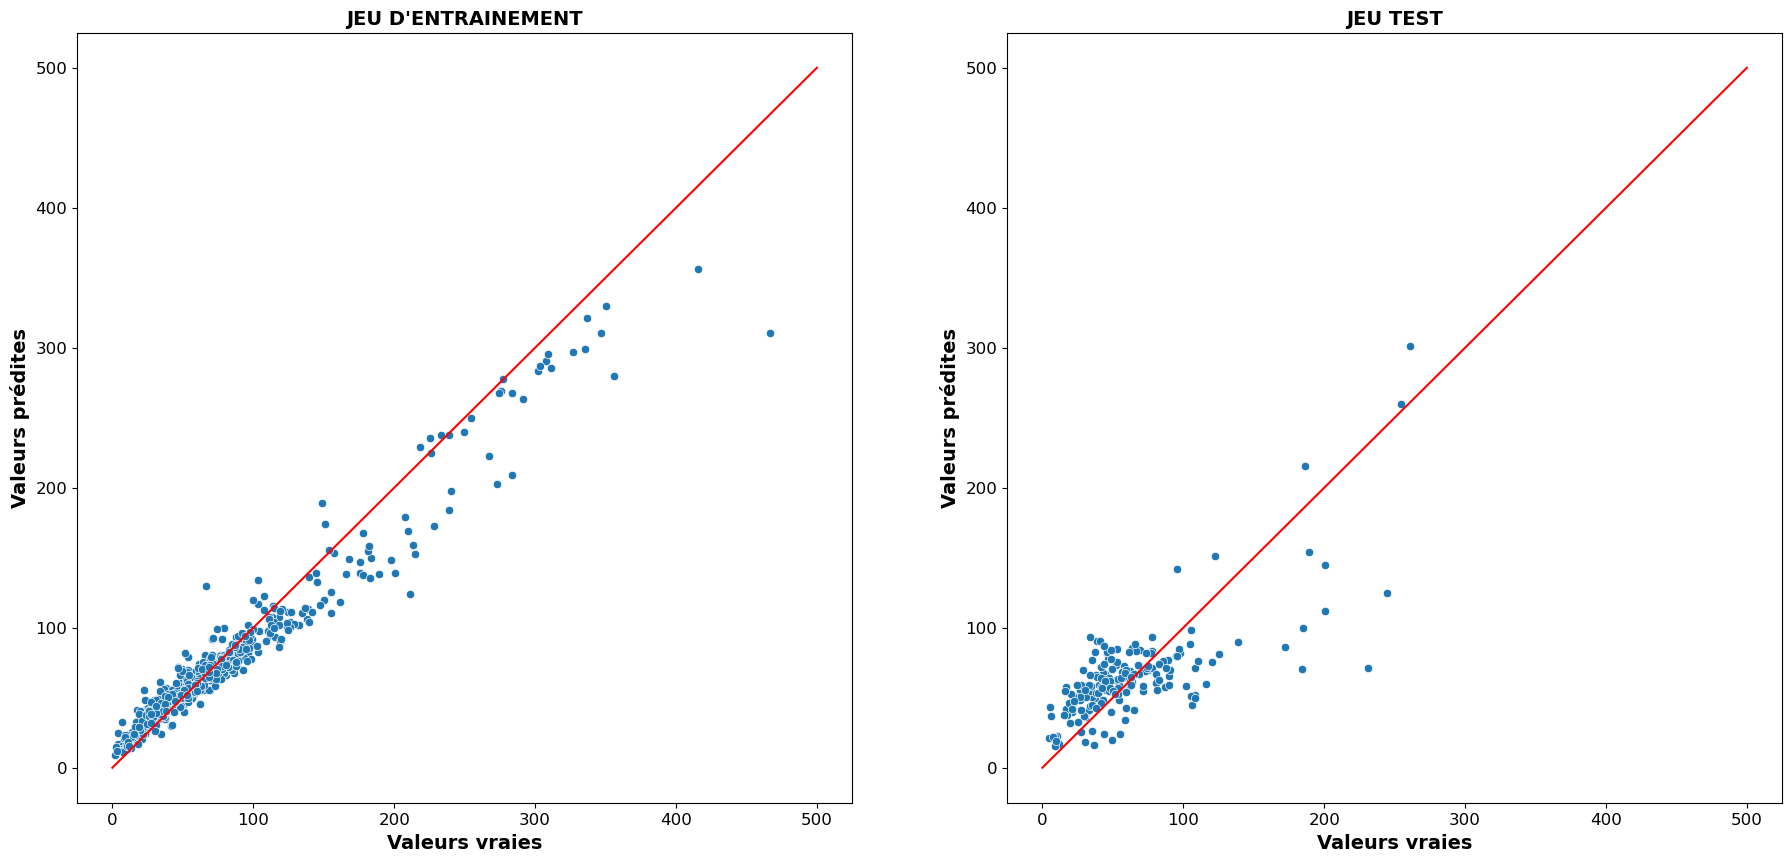

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (22,10))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":14})
    sns.scatterplot(ax=axes[0], x=y_train, y= y_rfr_train)
    sns.lineplot(ax=axes[0], x=np.linspace(0, 500, 50), y=np.linspace(0, 500, 50), color='r')
    axes[0].set_xlabel("Valeurs vraies", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_ylabel("Valeurs prédites", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_title("JEU D'ENTRAINEMENT", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax=axes[1], x=y_test, y= y_rfr_test)
    sns.lineplot(ax=axes[1], x=np.linspace(0, 500, 50), y=np.linspace(0, 500, 50), color='r')
    axes[1].set_xlabel("Valeurs vraies", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_ylabel("Valeurs prédites", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_title("JEU TEST", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    
plt.show()

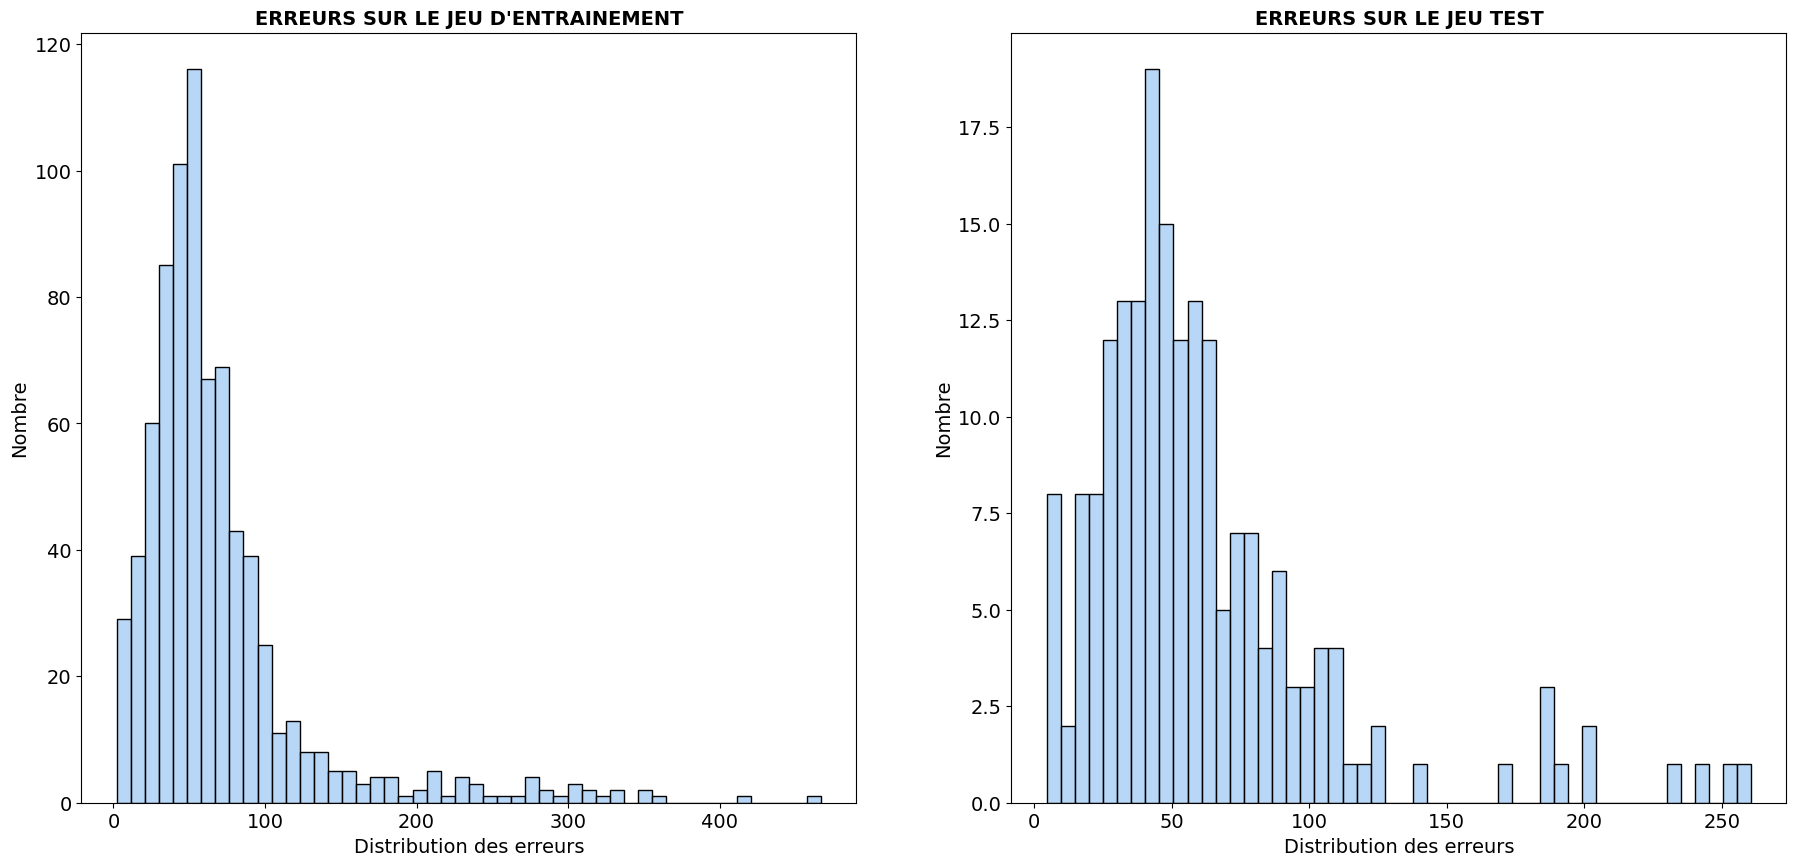

In [159]:
errors_train = np.abs(y_train, y_rfr_train)
errors_test = np.abs(y_test, y_rfr_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (22,10))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.histplot(ax=axes[0], x=errors_train, bins=50)
    axes[0].set_xlabel("Distribution des erreurs", fontname = 'sans-serif', fontsize = 14)
    axes[0].set_ylabel("Nombre", fontname = 'sans-serif', fontsize = 14)
    axes[0].set_title("ERREURS SUR LE JEU D'ENTRAINEMENT", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.histplot(ax=axes[1], x=errors_test, bins=50)
    axes[1].set_xlabel("Distribution des erreurs", fontname = 'sans-serif', fontsize = 14)
    axes[1].set_ylabel("Nombre", fontname = 'sans-serif', fontsize = 14)
    axes[1].set_title("ERREURS SUR LE JEU TEST", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    
plt.show()

## 4.2. La prédiction sur de nouvelles données (jeu de validation)

In [160]:
# Description de la target
validation["SiteEUIWN(kBtu/sf)"].describe()

count    516.000000
mean      88.836822
std       77.741134
min        1.500000
25%       37.775002
50%       65.850002
75%      112.474998
max      468.700012
Name: SiteEUIWN(kBtu/sf), dtype: float64

### 1. Entrainement du modèle sur de nouvelles données

In [161]:
X_val = validation.drop(["ENERGYSTARScore", "SiteEUIWN(kBtu/sf)", "GHGEmissionsIntensity"], axis=1)
y_val = validation["SiteEUIWN(kBtu/sf)"]

In [162]:
rfr_val = RandomForestRegressor(criterion='absolute_error', max_depth=32, max_features='sqrt', n_estimators = 800, random_state= 42)

In [163]:
# Entrainement du modèle
rfr_val.fit(X_val,y_val)

# Prédiction sur le jeu d'évaluation
y_pred_val = rfr_val.predict(X_val)

# Scores sur le jeu de validation
score_r2_val = r2_score(y_val,y_pred_val)
score_RMSE_val = np.sqrt(mean_squared_error(y_val,y_pred_val))
score_MSE_val = mean_squared_error(y_val, y_pred_val)
score_MAE_val = mean_absolute_error(y_val, y_pred_val)

print(f'R²: {score_r2_val}')
print(f'RMSE: {score_RMSE_val}')
print(f'MSE: {score_MSE_val}')
print(f'MAE: {score_MAE_val}')

R²: 0.8925655307846055
RMSE: 25.456661947625648
MSE: 648.0416375156916
MAE: 17.82546598156696


In [164]:
# Pourcentage d'erreurs du modèle

print(1-rfr_val.score(X_val, y_val))

0.10743446921539446


### 2. Comparaison des valeurs prédites et des valeurs réelles

In [165]:
y_vrai = pd.DataFrame(y_val)
y_predit = pd.DataFrame(y_pred_val)

data_plot = pd.concat([y_vrai, y_predit], axis = 1)
data_plot.rename(columns={"SiteEUIWN(kBtu/sf)": "y_vrai", 0: "y_predit"}, inplace = True)
data_plot.head()

,y_vrai,y_predit
5,141.600006,136.792628
7,68.800003,33.778187
14,51.099998,175.458502
15,78.400002,76.035500
17,137.100006,91.264815


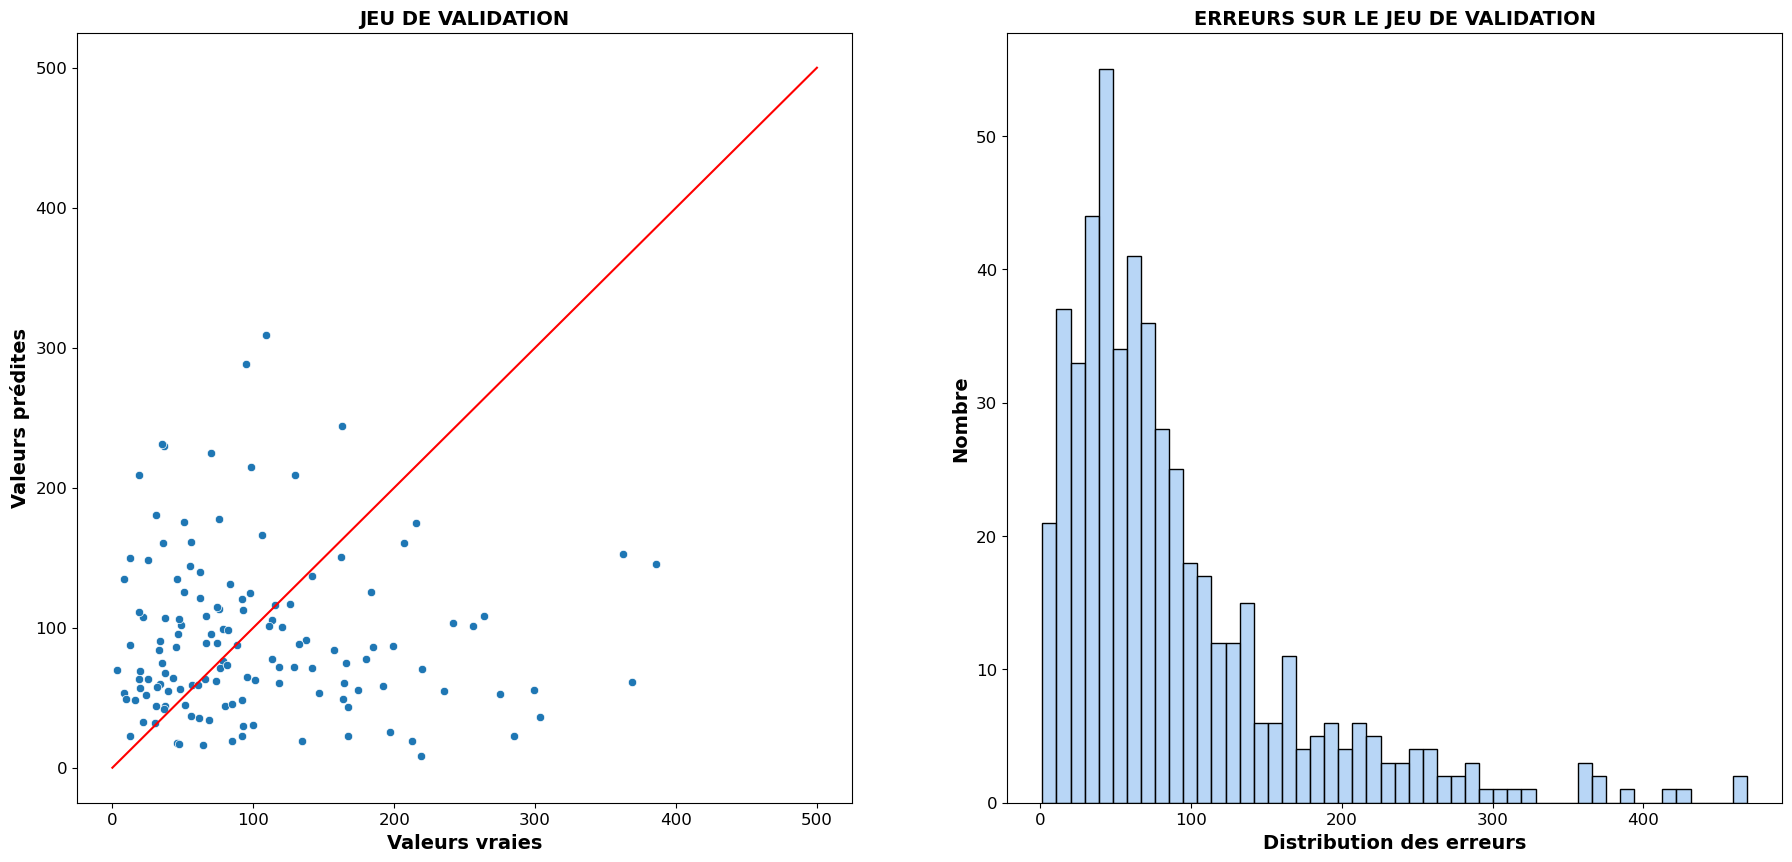

In [166]:
errors_val = np.abs(y_val, y_pred_val)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (22,10))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax=axes[0], data=data_plot, x='y_vrai', y= 'y_predit')
    sns.lineplot(ax=axes[0], x=np.linspace(0, 500, 50), y=np.linspace(0, 500, 50), color='r')
    axes[0].set_xlabel("Valeurs vraies", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_ylabel("Valeurs prédites", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_title("JEU DE VALIDATION", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.histplot(ax=axes[1], x=errors_val, bins=50)
    axes[1].set_xlabel("Distribution des erreurs", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_ylabel("Nombre", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_title("ERREURS SUR LE JEU DE VALIDATION", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    
plt.show()

**La performance de notre modèle est d'environ 90% avec un pourcentage d'erreurs avoisinant les 10%, ce qui en soit me semble pertinent vu la quantité de données à disposition pour l'apprentissage. Lorsque nous observons la distribution des erreurs, nous pouvons remarquer que nous avons la majorité des erreurs qui sont de faible ampleur. Afin d'avoir un modèle plus robuste, il faudrait fournir davantage de données pour l'apprentissage ce qui est impossible dans notre cas.**

## 4.2. L'importance des variables

### 1. L'importance des variables sur l'entrainement du modèle: feature_importances_

In [167]:
# Sous forme d'array
rfr_3_importances = rfr_3.feature_importances_
print(rfr_3_importances)

# Transformation en pd.Series
forest_importances = pd.Series(rfr_3_importances)

[0.00351648 0.05933647 0.10799361 0.01249449 0.1009357  0.09099767
 0.09666481 0.00819738 0.14358163 0.00224772 0.04546161 0.0049899
 0.05103274 0.03658291 0.00569681 0.01579919 0.02106991 0.00195232
 0.02419539 0.05193096 0.00935593 0.004413   0.0118432  0.00813432
 0.00980593 0.01405213 0.00869382 0.00894014 0.0064602  0.01237806
 0.01005184 0.00595313 0.00524062]


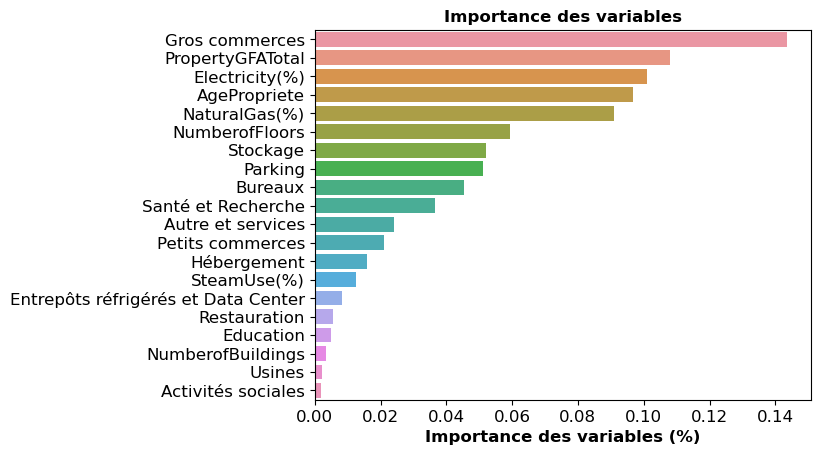

In [168]:
importances = forest_importances.head(20)
idx = X.columns

i, v =[],[]
for i_0, v_0 in sorted(zip(importances, idx), reverse =True):
    i.append(i_0)
    v.append(v_0)
    with sns.color_palette(palette="pastel"):
        plt.rcParams.update({"font.size":12})
        sns.barplot(x=i, y=v)
        plt.xlabel("Importance des variables (%)", fontname="sans-serif", fontsize=12, fontweight="bold")
        plt.xlim()
        plt.xticks()
        plt.title("Importance des variables", fontname="sans-serif", fontsize=12, fontweight="bold")
    
plt.show()

**Les 10 features les plus importantes pour l'entraînement de modèle sont respectivement:**
- **Le secteur d'activité "Gros commerces"**
- **La superficie totale de la propriété**
- **La part d'électricité en % dans les énergies utilisées**
- **L'âge de la propriété**
- **La part de gaz naturel en % dans les énergies utilisées**
- **Le nombre d'étages**
- **Le secteur d'activité 'Stockage'**
- **Les parking**
- **Les bureaux**
- **Le secteur d'activité 'Santé et Recherches'**
- **Le secteur d'activité 'Autre et Services'**

### 2. L'importance des variables sur la prédiction du modèle: les valeurs de Shapley

**Elles permettent, pour une observation donnée, de quantifier l'impact de chaque feature de cette observation sur la prédiction qui lui est associée par le modèle.**

In [169]:
# Fits the explainer
explainer = shap.TreeExplainer(rfr_3)

# Calculates the SHAP values - It takes some time
shap_values = explainer.shap_values(X_train)

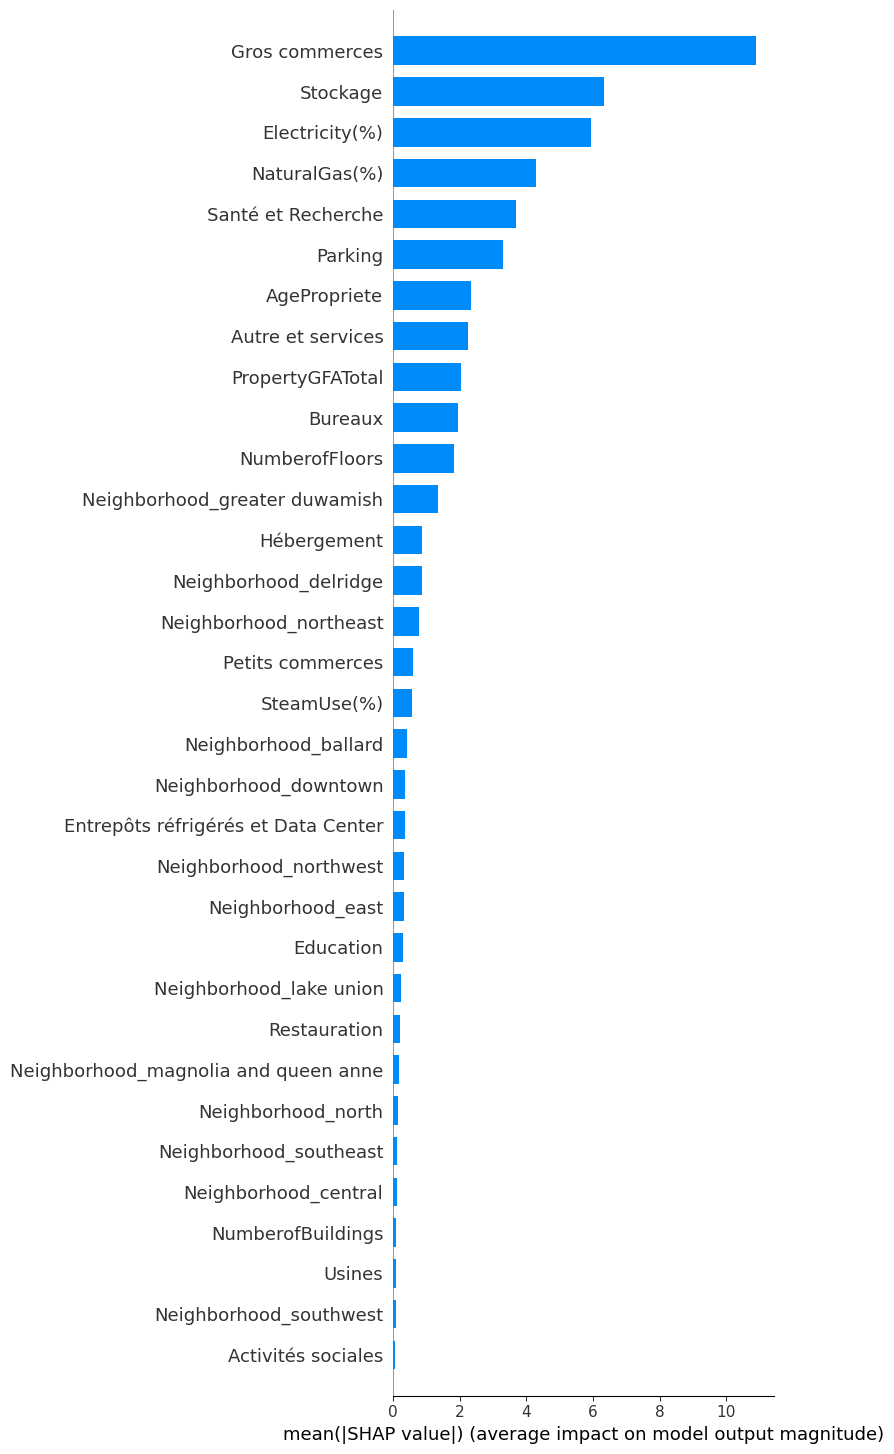

In [170]:
shap.summary_plot(shap_values, feature_names=X.columns, plot_type='bar', max_display=33)

**Les 10 features contribuant en moyenne le plus à la prédiction du modèle sont respectivement:**
- **Le secteur d'activité "Gros commerces"**
- **Le secteur d'activité 'Stockage'**
- **La part d'électricité en % dans les énergies utilisées**
- **La part de gaz naturel en % dans les énergies utilisées**
- **Le secteur d'activité 'Santé et Recherches'**
- **Les parking**
- **L'âge de la propriété**
- **Le secteur d'activité 'Autre et Services'**
- **La superficie totale de la propriété**
- **Les bureaux**

### CONCLUSION
- **Modèle utilisable en l'état**
- **Modèle qui pourrait être plus robuste avec des relevés supplémentaires (même si couteux)**